In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
# for todays date
from datetime import date as dt
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import datetime as dt
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pyvinecopulib as pv
import seaborn as sns

import datetime as dt
import pandas as pd
import plotly.offline as pyo
import numpy as np
import seaborn as sns
import tqdm

pyo.init_notebook_mode(connected=True)

pd.options.plotting.backend = 'plotly'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import matplotlib.pyplot as plt
import pyvinecopulib as pv


from pairlib import pair_selection

In [2]:
# get stocks from wikipedia
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData

# url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# req = Request(url=url, headers={'user-agent': 'my-app'})
# response = urlopen(req)
# html = BeautifulSoup(response, 'html')
# table = html.find(id="constituents")

# rows = table.findAll('tr')
# stocks = []
# for index, row in enumerate(rows):
#     ticker = row.a.text
#     stocks.append(ticker)

# stocks = stocks[1:] # drop the column name

with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/constituents.pkl', 'rb') as f:
    stocks = pickle.load(f)
stocks[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [3]:
# download the data
# end = dt.datetime(2023, 1, 1)
# start = dt.datetime(2021,1,1)

# data = get_data(stocks, start, end)
# # drop all columns with nan values
# data = data.dropna(axis=1)
# with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/data.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/data/data.pkl', 'rb') as f:
        data = pickle.load(f)

In [4]:
pair_selector = pair_selection(data)
pairs = pair_selector.kendall_tau()
pair = pairs[0] # ('GOOG', 'GOOGL')
pairs

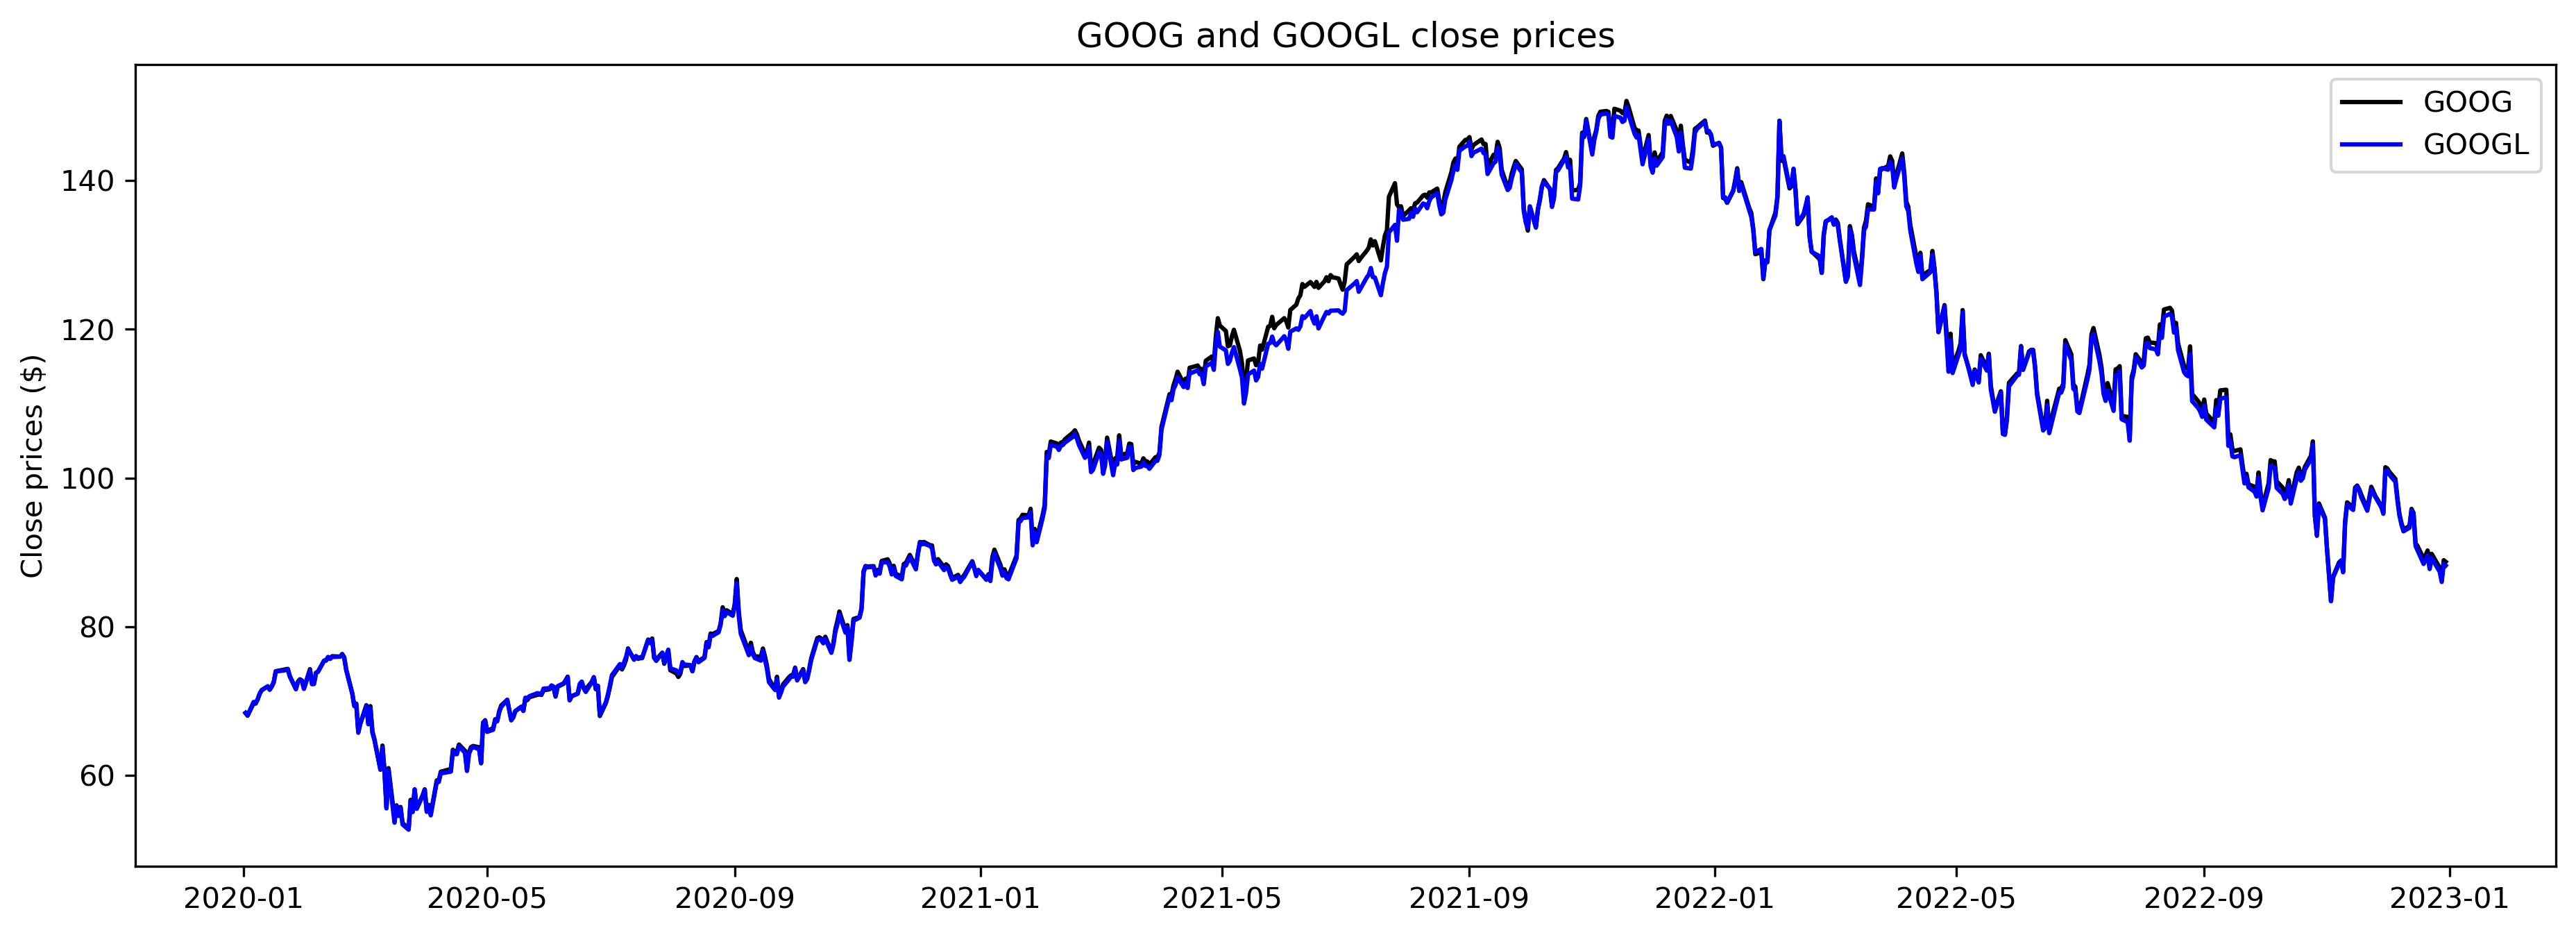

In [6]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(data.index, data[pair[0]], color='black')
plt.plot(data.index, data[pair[1]], color='blue')


plt.legend([pair[0], pair[1]])
plt.title(f'{pair[0]} and {pair[1]} close prices')
plt.ylabel('Close prices ($)')
plt.show()

In [7]:
x, y, u = pair_selector.get_variables()

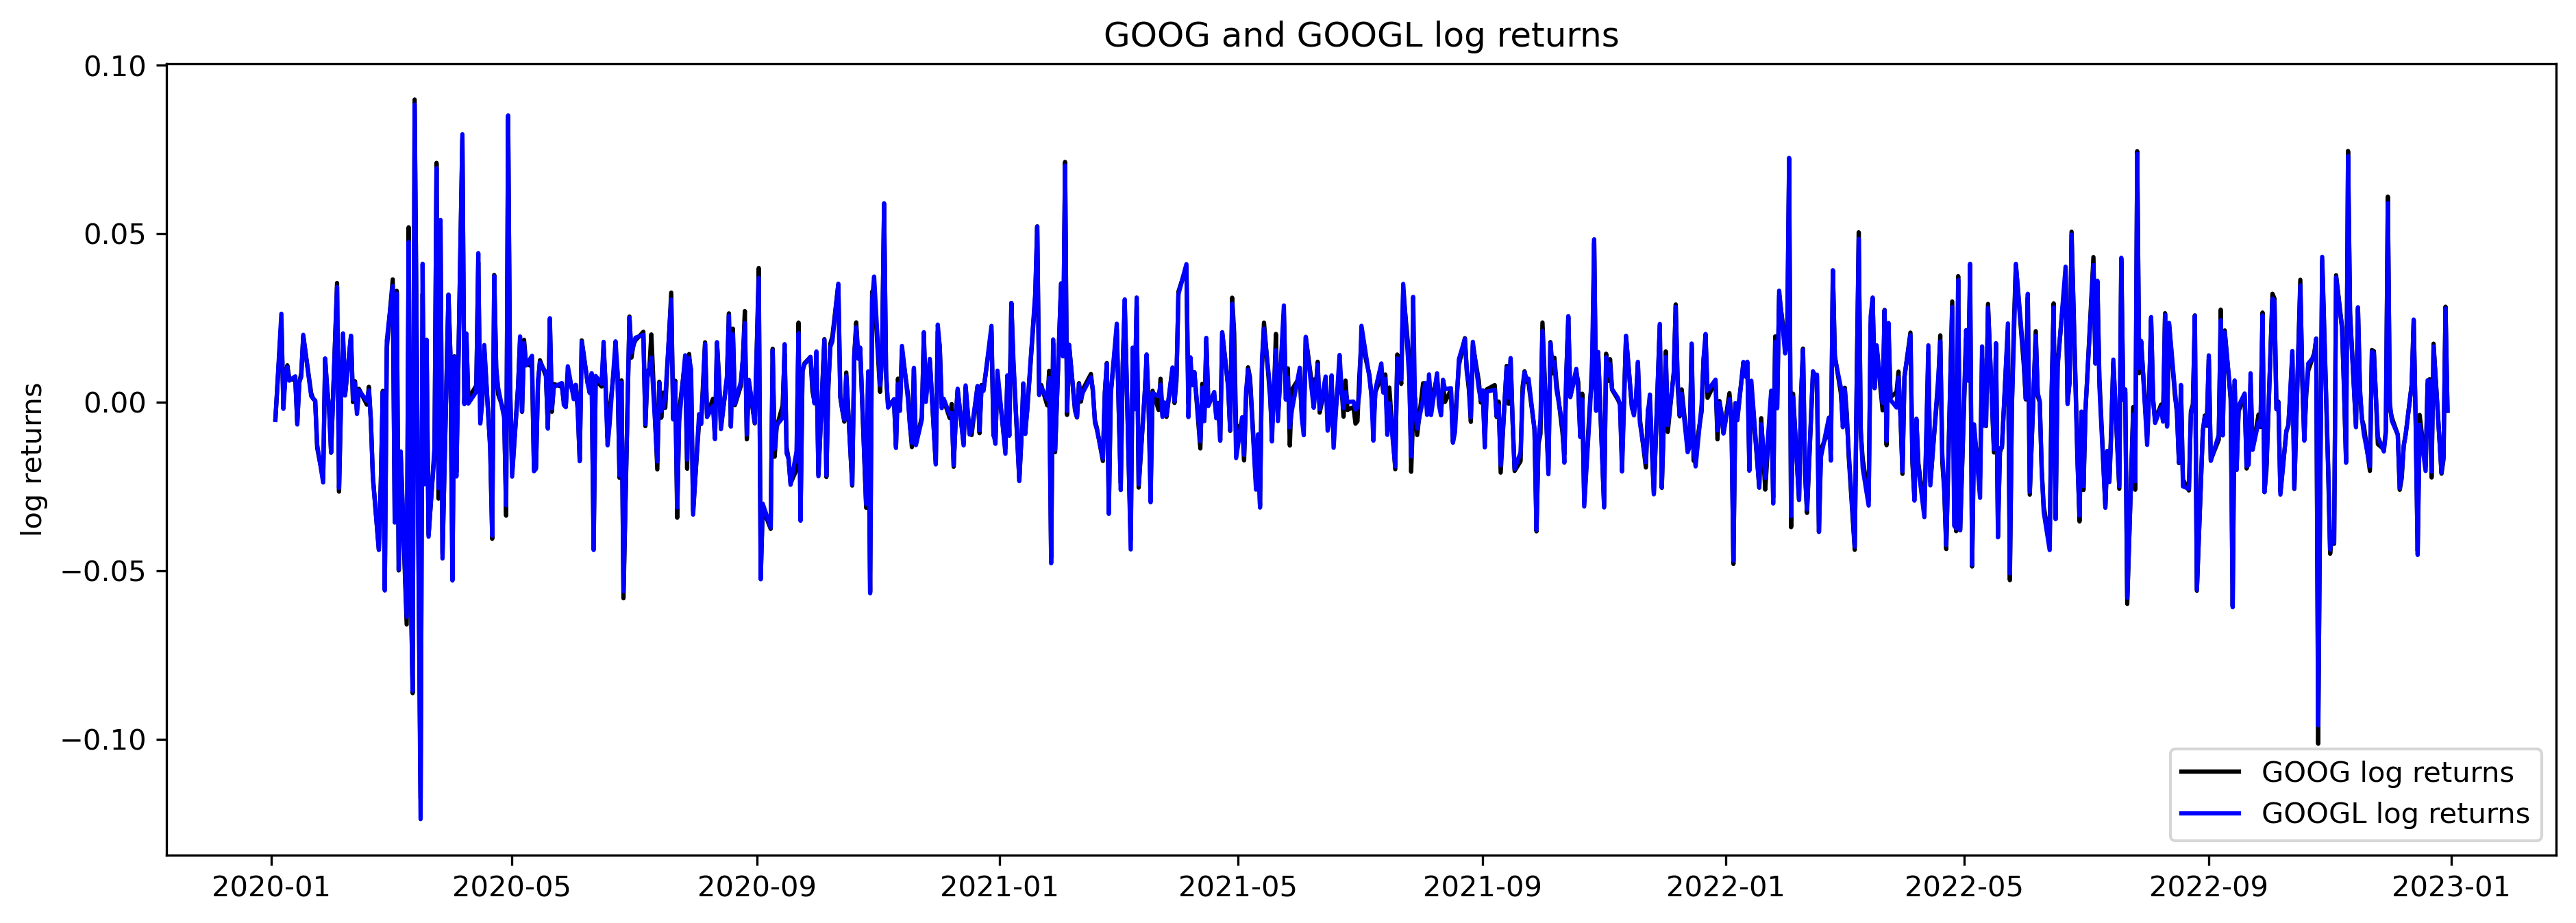

In [8]:
plt.figure(figsize=(15,5))
plt.plot(x.index, x, color='black')
plt.plot(y.index, y, color='blue')

plt.legend([f'{pair[0]} log returns', f'{pair[1]} log returns'])
plt.title(f'{pair[0]} and {pair[1]} log returns')
plt.ylabel('log returns')
plt.show()

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/jasperchong/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:11

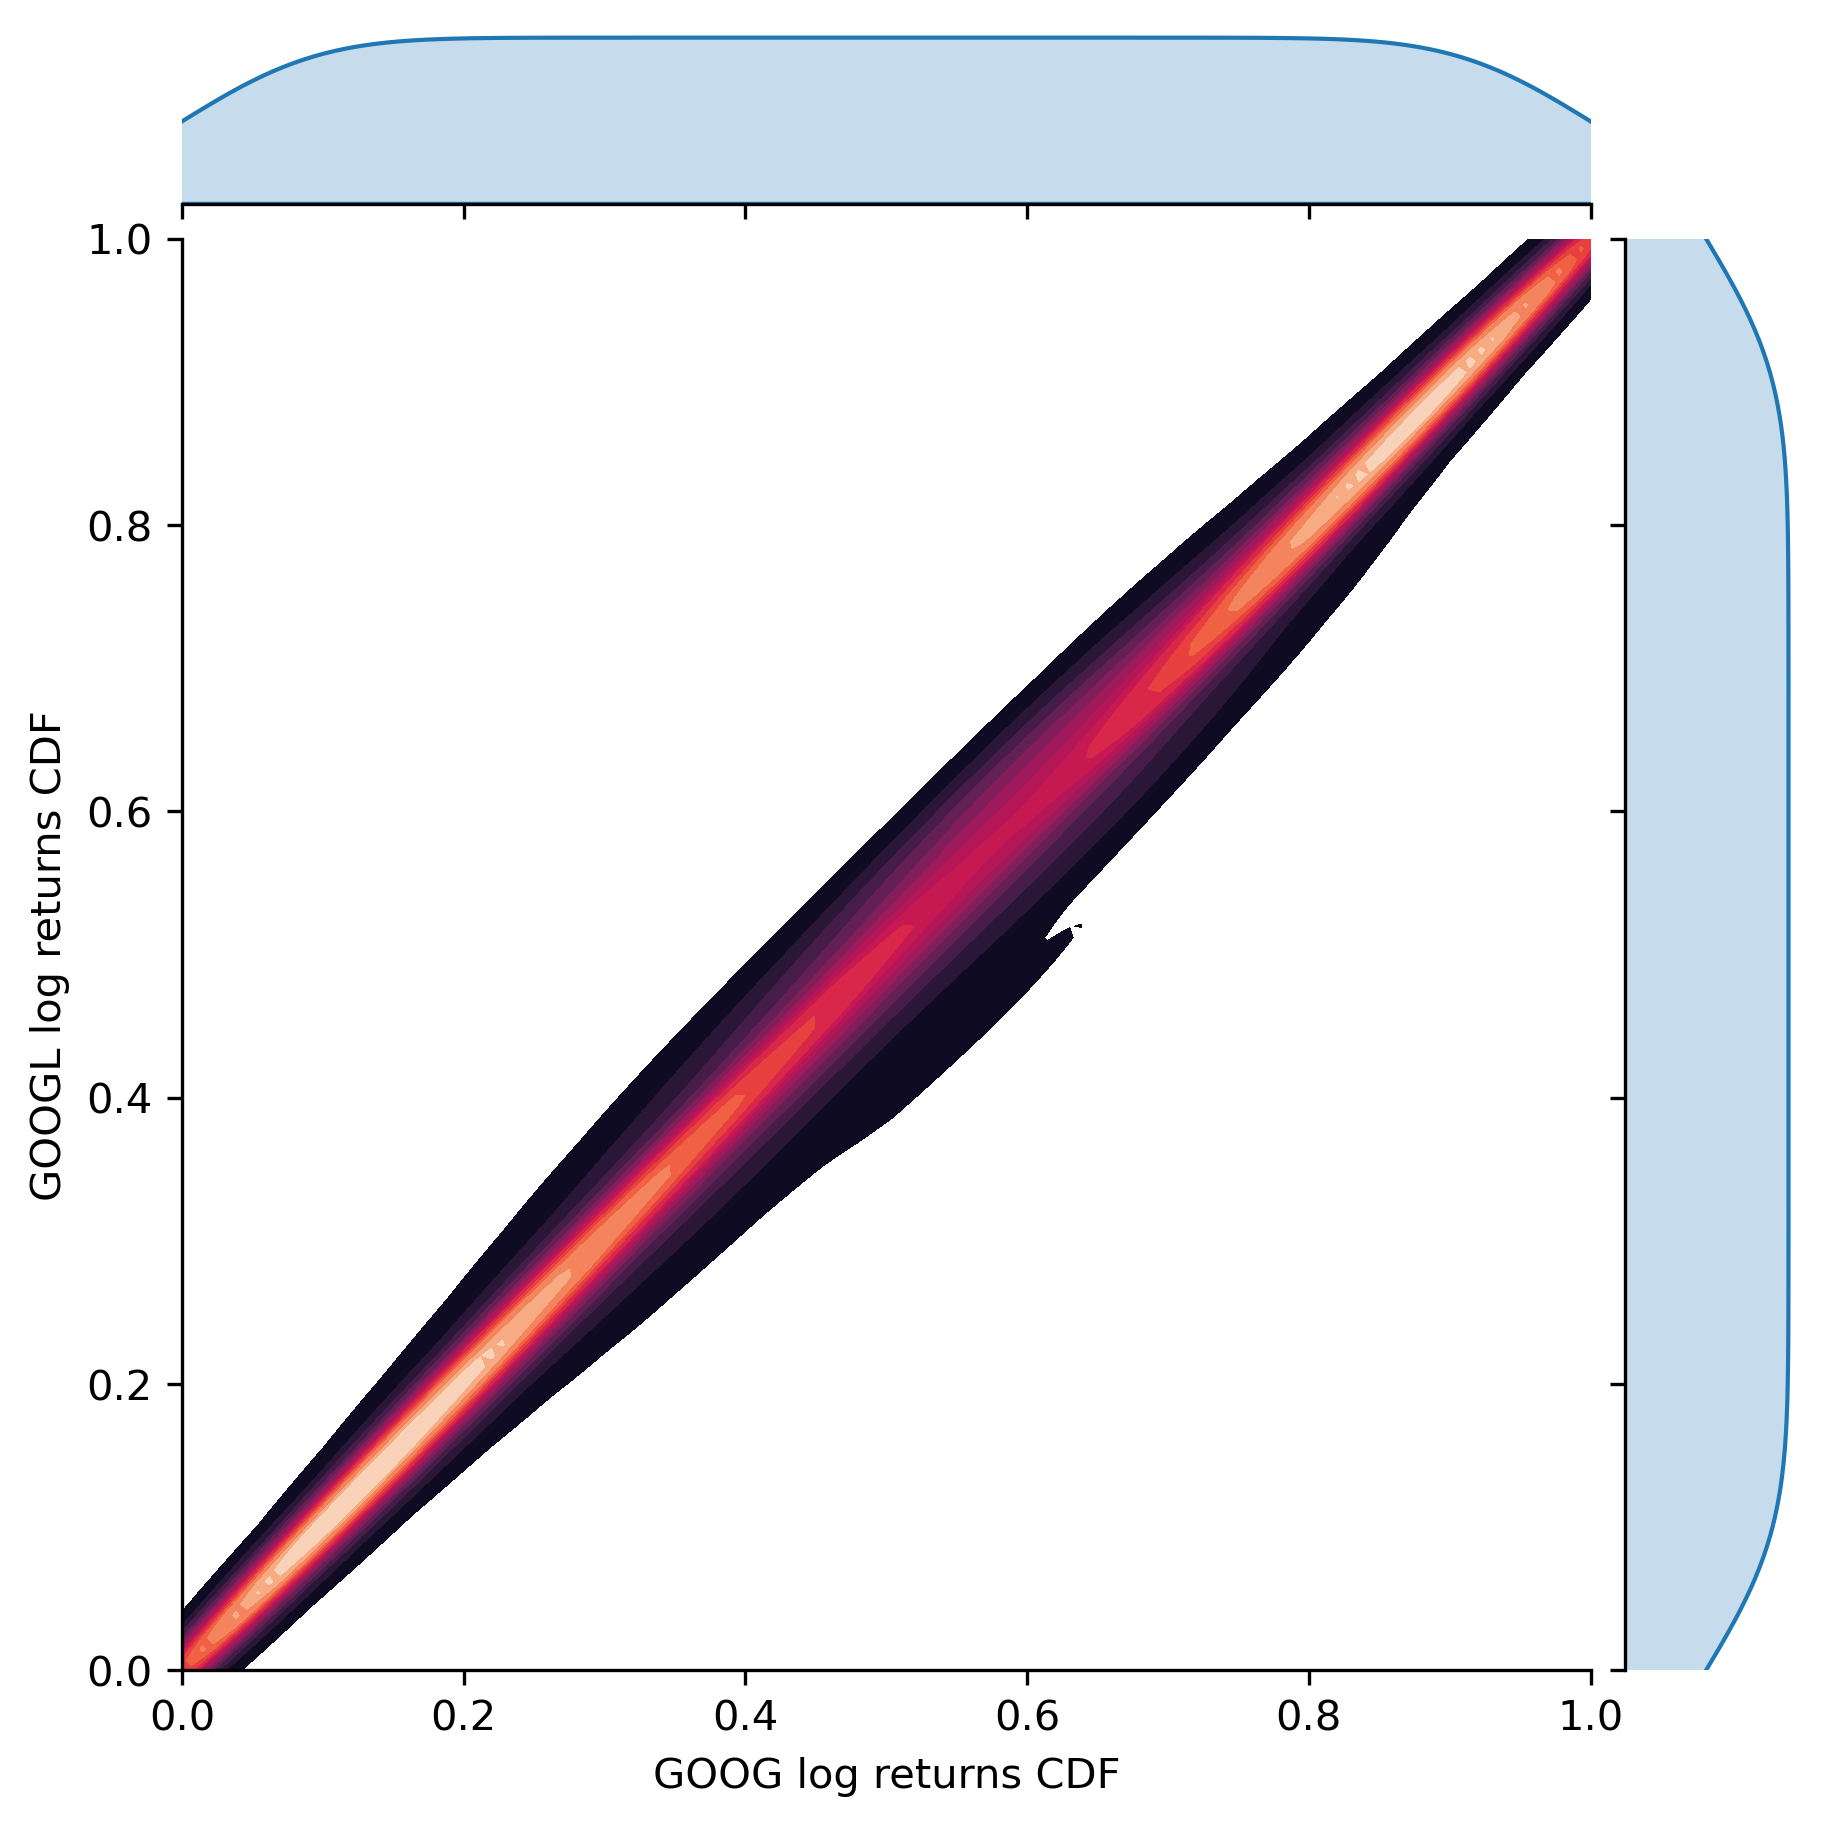

In [9]:
h = sns.jointplot(x=u.T[0], y=u.T[1], kind="kde", xlim=(0,1), ylim=(0,1), ratio=7, cmap="rocket", fill=True, n_levels=15)
_ = h.set_axis_labels(f"{pair[0]} log returns CDF", f"{pair[1]} log returns CDF")

strategy one from writeup

In [207]:
def get_variables(S1, S2): # drops the first term
    x = (np.log(S1) - np.log(S1.shift(1)))[1:]
    y = (np.log(S2) - np.log(S2.shift(1)))[1:]
    # combine them into one array and transpose to make columns
    xy = np.array([x, y]).T
    # get the empirical distribution
    u = pv.to_pseudo_obs(xy)
    return x, y, u


def get_model(u):
    model = pv.Bicop(data=u)
    return model


def mispricing_index(model, u):
    MI_v_u = model.hfunc1(u)
    MI_u_v = model.hfunc2(u)
    return MI_u_v, MI_v_u


def simulate_trades(S1, S2, lookback=150):
    # Setup stating parametesrs
    # Starting signals
    flagX = 0*S1 # trading indicators
    flagY = 0*S1 

    weightY = 1
    n_X = 0
    n_Y = 0
    n_trades = 0
    returns = 0
    # numbers taken from paper
    D = 0.49 # trigger point from [-0.5, 0.5]
    S = 2 # Stop loss position

    # Series
    rs = 0*S1
    MI_x_ys = 0*S1
    MI_y_xs = 0*S1
    copList = []

    for i in range(lookback+1, len(S1), 1):
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]

        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI_x_y, MI_y_x = mispricing_index(cop, u)
        MI_x_ys[i], MI_y_xs[i] = MI_x_y[-1], MI_y_x[-1]
        ## Update copula

        # accumulations of the daily (MI_x_y-0.5) and (MI_y_x-0.5)
        flagX[i] = flagX[i-1] + (MI_x_ys[i]-0.5)
        flagY[i] = flagX[i-1] + (MI_y_xs[i]-0.5)

        #todo may want to make it so the if statement is "reaches", not < or >
        #todo implement stop loss


        #* When FlagX reaches D, we short-sell stock X and buy stock Y in equal amounts.
        #* When FlagY reaches -D, we short-sell stock X and buy stock Y in equal amounts.
        
        if flagX[i] > D or flagY[i] < -D:
            # buy stock Y
            n_Y +=  weightY
            returns -= weightY*S2[i]

            # should you use a proportion?
            # Short sell stock X
            n_X -= weightY
            returns += weightY*S1[i]

            n_trades += 1

        #? When FlagX reaches -D, we short-sell stock Y and buy stock X in equal amounts.
        #? When FlagY reaches D, we short-sell stock Y and buy stock X in equal amounts.
        elif flagX[i] < -D or flagY[i] > D:
            # short sell stock Y
            n_Y -=  weightY
            returns += weightY*S2[i]

            # should you use a proportion?
            # buy X
            n_X += weightY
            returns -= weightY*S1[i]

            n_trades += 1
        
        #! If flagX or flagY pass the stop loss, exit all positions
        if abs(flagX[i]) > S or abs(flagY[i]) > S:
            returns += n_X*S1[i] + n_Y*S2[i] 
            n_X = 0
            n_Y = 0

            flagX[i] = 0
            flagY[i] = 0
        rs[i] = returns + n_X*S1[i] + n_Y*S2[i]
    
    return rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs

# the two stocks we chose
S1 = data[pair[0]]
S2 = data[pair[1]]

rs, flagX, flagY, n_trades, copList, MI_x_ys, MI_y_xs  = simulate_trades(S1, S2)
n_trades

444

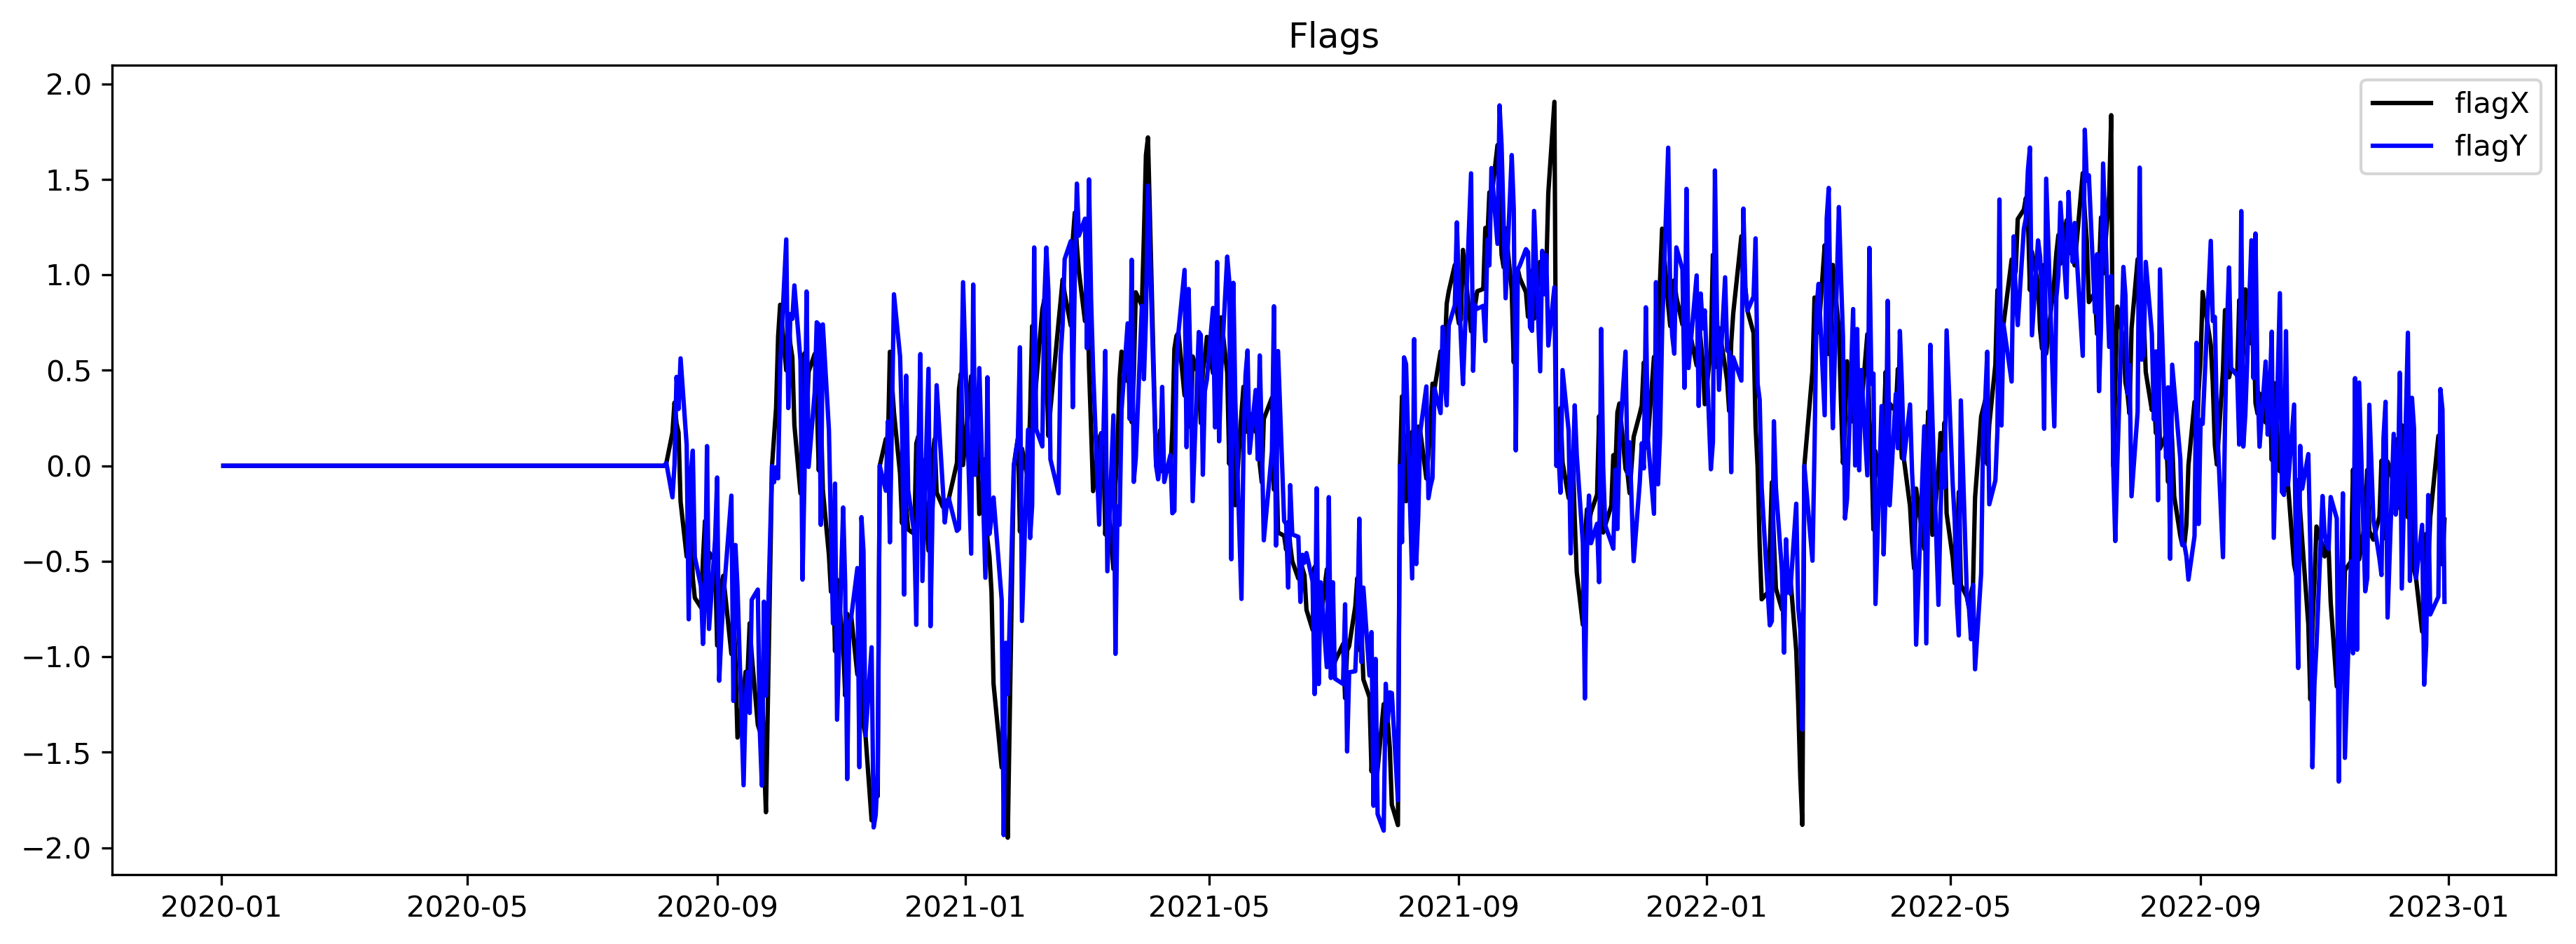

In [208]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(flagX, color='black')
plt.plot(flagY, color='blue')

plt.legend(['flagX', 'flagY'])
plt.show()

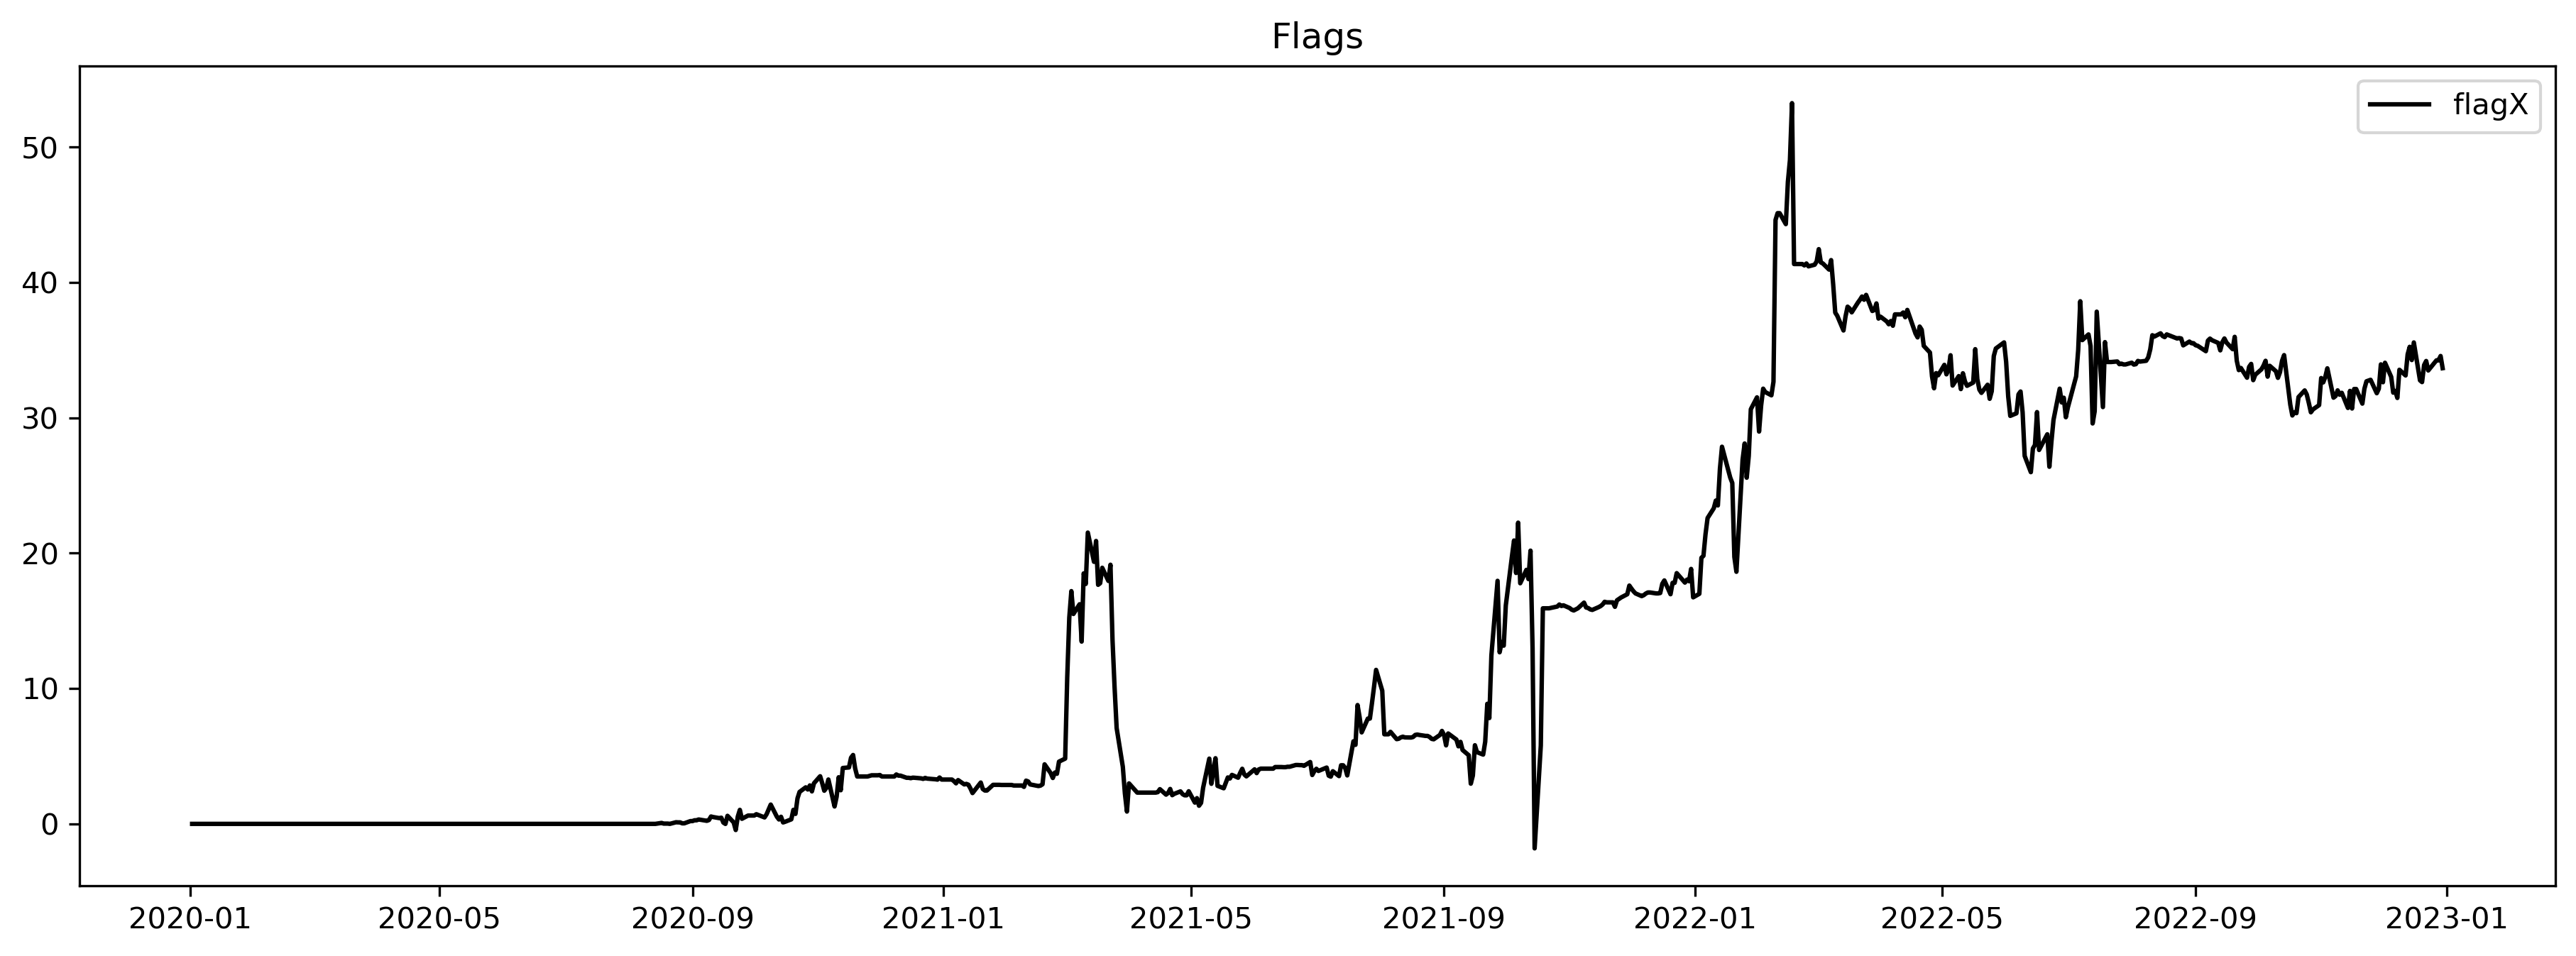

In [210]:
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
plt.plot(rs, color='black')

plt.legend(['flagX', 'flagY'])
plt.show()

In [211]:
def simulate_trades_revised(S1, S2, lookback=150, weight_S2=1):

    ### Trading variables
    upper_CB = 0.95 # upper confidence bound
    lower_CB = 0.05 # lower confidence bound
    EB = 0.5 # Exit bound

    ### Form timeseries
    returns = 0*S1
    totalReturns = 0*S1
    n_S1 = 0*S1
    n_S2 = 0*S1
    MI_u_v = 0*S1 # Mispricing Index of S1 given S2
    MI_v_u = 0*S1 # Mispricing Index of S2 given S1
    copList = []

    ### Testing
    n_trades =0

    for i in range(lookback+1, len(S1), 1): # add 1 to avoid the nan at start

        returns[i] = returns[i-1]
        totalReturns[i] = totalReturns[i-1]

        n_S1[i] = n_S1[i-1]
        n_S2[i] = n_S2[i-1]

        ## Setup the copula
        rolling_S1 = S1[i-(lookback+1):i]
        rolling_S2 = S2[i-(lookback+1):i]
        # log returns
        x, y, u = get_variables(rolling_S1, rolling_S2)

        cop = get_model(u)
        copList.append(cop.family)
        MI1, MI2 = mispricing_index(cop, u)
        MI_u_v[i], MI_v_u[i] = MI1[-1], MI2[-1]

        # coef = stats.linregress(x, y).slope
        coef = 1
        ## Make trades 
        price_S1, price_S2 = rolling_S1[-1], rolling_S2[-1]
        
        # if S1 is undervalued and S2 is overvalued, go long
        # Sell S2 by weight, and buy S1 by weight * coefficient * long/short price ratio
        if MI_u_v[i] < lower_CB and MI_v_u[i] > upper_CB:
            # sell S2 by weight
            n_S2[i] -= weight_S2
            returns[i] += weight_S2*price_S2
            # buy S1 by weight * coefficient * long/short price ratio
            n_S1[i] += (weight_S2 * coef * (price_S1/price_S2))
            returns[i] -= (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            # buy[i] = price_S1
            # sell[i] = price_S2

            n_trades += 1

        # Buy S2 by weight, sell S1 by weight * coefficient * long/short price ratio
        elif MI_u_v[i] > lower_CB and MI_v_u[i] < upper_CB:
            # buy S2 by weight
            n_S2[i] += weight_S2
            returns[i] -= weight_S2*price_S2
            # sell S1 by weight * coefficient * long/short price ratio
            n_S1[i] -= (weight_S2 * coef * (price_S1/price_S2))
            returns[i] += (weight_S2 * coef * (price_S1/price_S2))*price_S1
            # update timeseries
            # sell[i] = price_S1
            # buy[i] = price_S2

            n_trades += 1

        # if it crosses the exit threshold, liquidate positions
        elif ((MI_u_v[i] < EB and MI_u_v[i-1] > EB) or (MI_u_v[i] > EB and MI_u_v[i-1] < EB)) \
         and ((MI_v_u[i] < EB and MI_v_u[i-1] > EB) or (MI_v_u[i] > EB and MI_v_u[i-1] < EB)):
            
            returns[i] += n_S1[i]*price_S1 + n_S2[i]*price_S2
            n_S1[i] = 0
            n_S2[i] = 0

            # liquidateS1[i] = price_S1
            # liquidateS2[i] = price_S2

        totalReturns[i] = returns[i] + n_S1[i]*price_S1 + n_S2[i]*price_S2

    return totalReturns, n_S1, n_S2, MI_u_v, MI_v_u, copList, n_trades

S1 = data[pair[0]]
S2 = data[pair[1]]

totalReturns, n_S1, n_S2, MI_u_v, MI_v_u, copList, n_trades = simulate_trades_revised(S1, S2)
n_trades

598

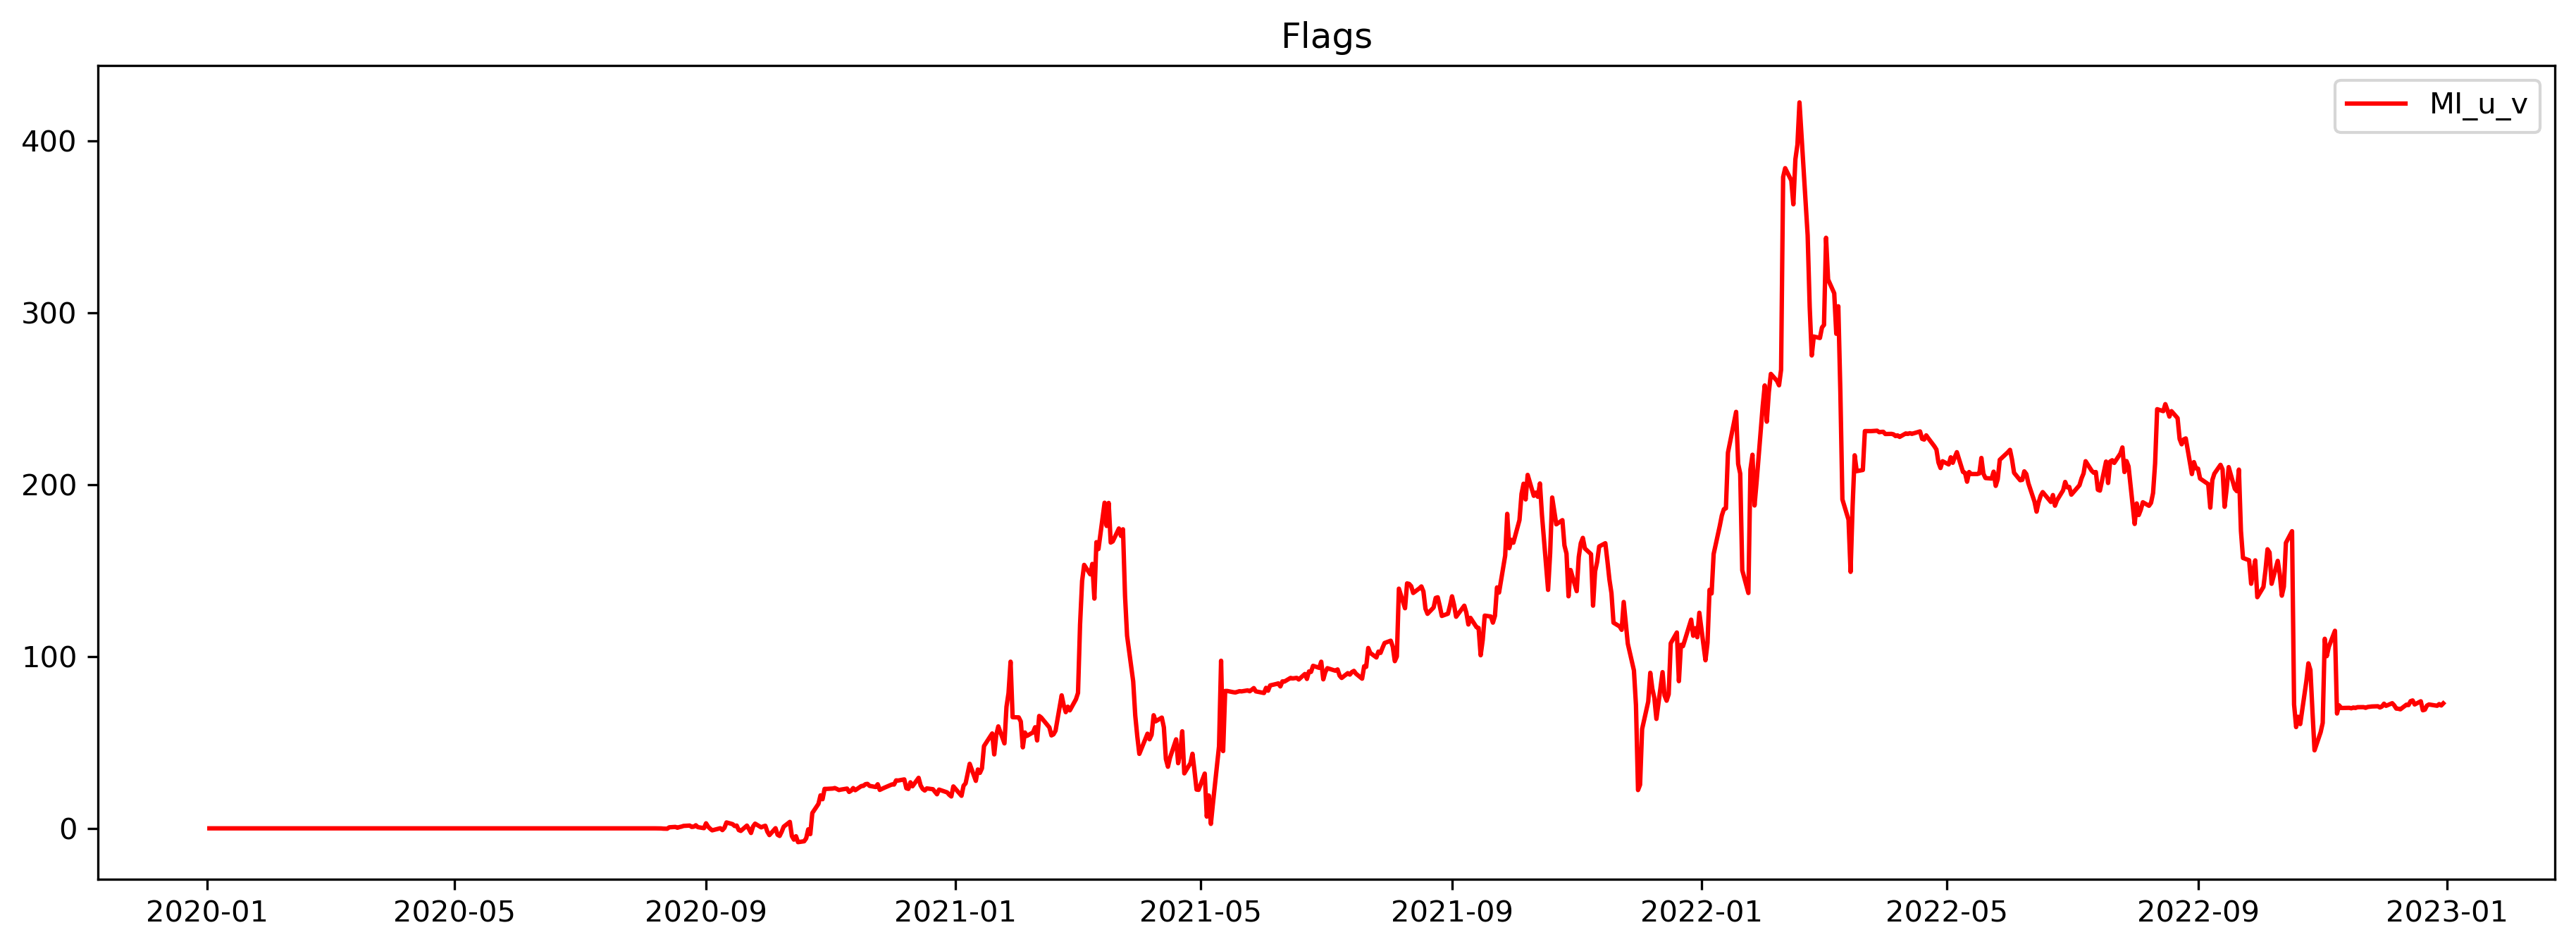

In [214]:
# plot mispricing index
# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Flags")
# plt.plot(MI_u_v, color='black')
# plt.plot(MI_v_u, color='blue')
plt.plot(totalReturns, color='red')

plt.legend(['MI_u_v', 'MI_v_u'])
plt.show()

In [203]:

def moving_data(data, window, std=False, z=False, min_periods=None):
    # min periods is to prevent having no data at start
    d_ma = data.rolling(window=window, center=False, min_periods=None).mean()
    if std or z:
        d_std = data.rolling(window=window, center=False, min_periods=None).std()
        if std:
            return d_ma, d_std
    if z:
        d_z = (data-d_ma)/d_std
        return d_ma, d_std, d_z
    return d_ma

# testing cointegration approach
def trade(S1, S2, window, threshold, exit_threshold, start_S1=0, start_S2=0): # use the testing data for S1 and S2
    S1 = S1[window:]
    S2 = S2[window:]
    ratio = S1/S2
    r_MA, r_STD, r_Z = moving_data(ratio, window, z=True)

    # variables for graphing
    returns_S = 0*ratio.copy()
    amount_S1_S = 0*ratio.copy()
    amount_S2_S = 0*ratio.copy()
    buyR_S = 0*ratio.copy()
    sellR_S = 0*ratio.copy()

    # Simulate trading
    returns = 0
    amount_S1 = start_S1
    amount_S2 = start_S2
    initial = returns + amount_S1*S1[0] + amount_S2*S2[0]
    for i in range(len(ratio)):
        # sell the ratio if above the threshold, buy one S1 and sell one ratio*S2
        if r_Z[i] > threshold:
            # the returns are the price of S1 - the price of S2 * the amount of S2 bought
            returns += S1[i] - ratio[i]*S2[i]
            amount_S1 -= 1
            amount_S2 += ratio[i]*1
            sellR_S[i] = ratio[i]
            
        # buy the ratio 
        elif r_Z[i] < -threshold:
            # the returns is the cost of buying S1 + the returns of selling S2 * the amount of S2 sold
            returns += -S1[i] + ratio[i]*S2[i]
            amount_S1 += 1
            amount_S2 -= ratio[i]*1
            buyR_S[i] = ratio[i]

        # exit positions
        elif abs(r_Z[i]) < exit_threshold:
            returns += amount_S1*S1[i] + amount_S2*S2[i]
            amount_S1 = 0
            amount_S2 = 0
        
        # add values to time series
        returns_S[i] = returns
        amount_S1_S[i] = amount_S1
        amount_S2_S[i] = amount_S2

    total_returns = returns + amount_S1*S1[-1] + amount_S2*S2[-1]

    # return total returns, cash returns, anmount of S1 stock, amount of S2 stock, time series
    # output = {"Data":{"Total Returns":total_returns,"Returns"}}
    return total_returns, returns, amount_S1, amount_S2, initial, returns_S, amount_S1_S, amount_S2_S, buyR_S, sellR_S, ratio        

$55.192071110612424


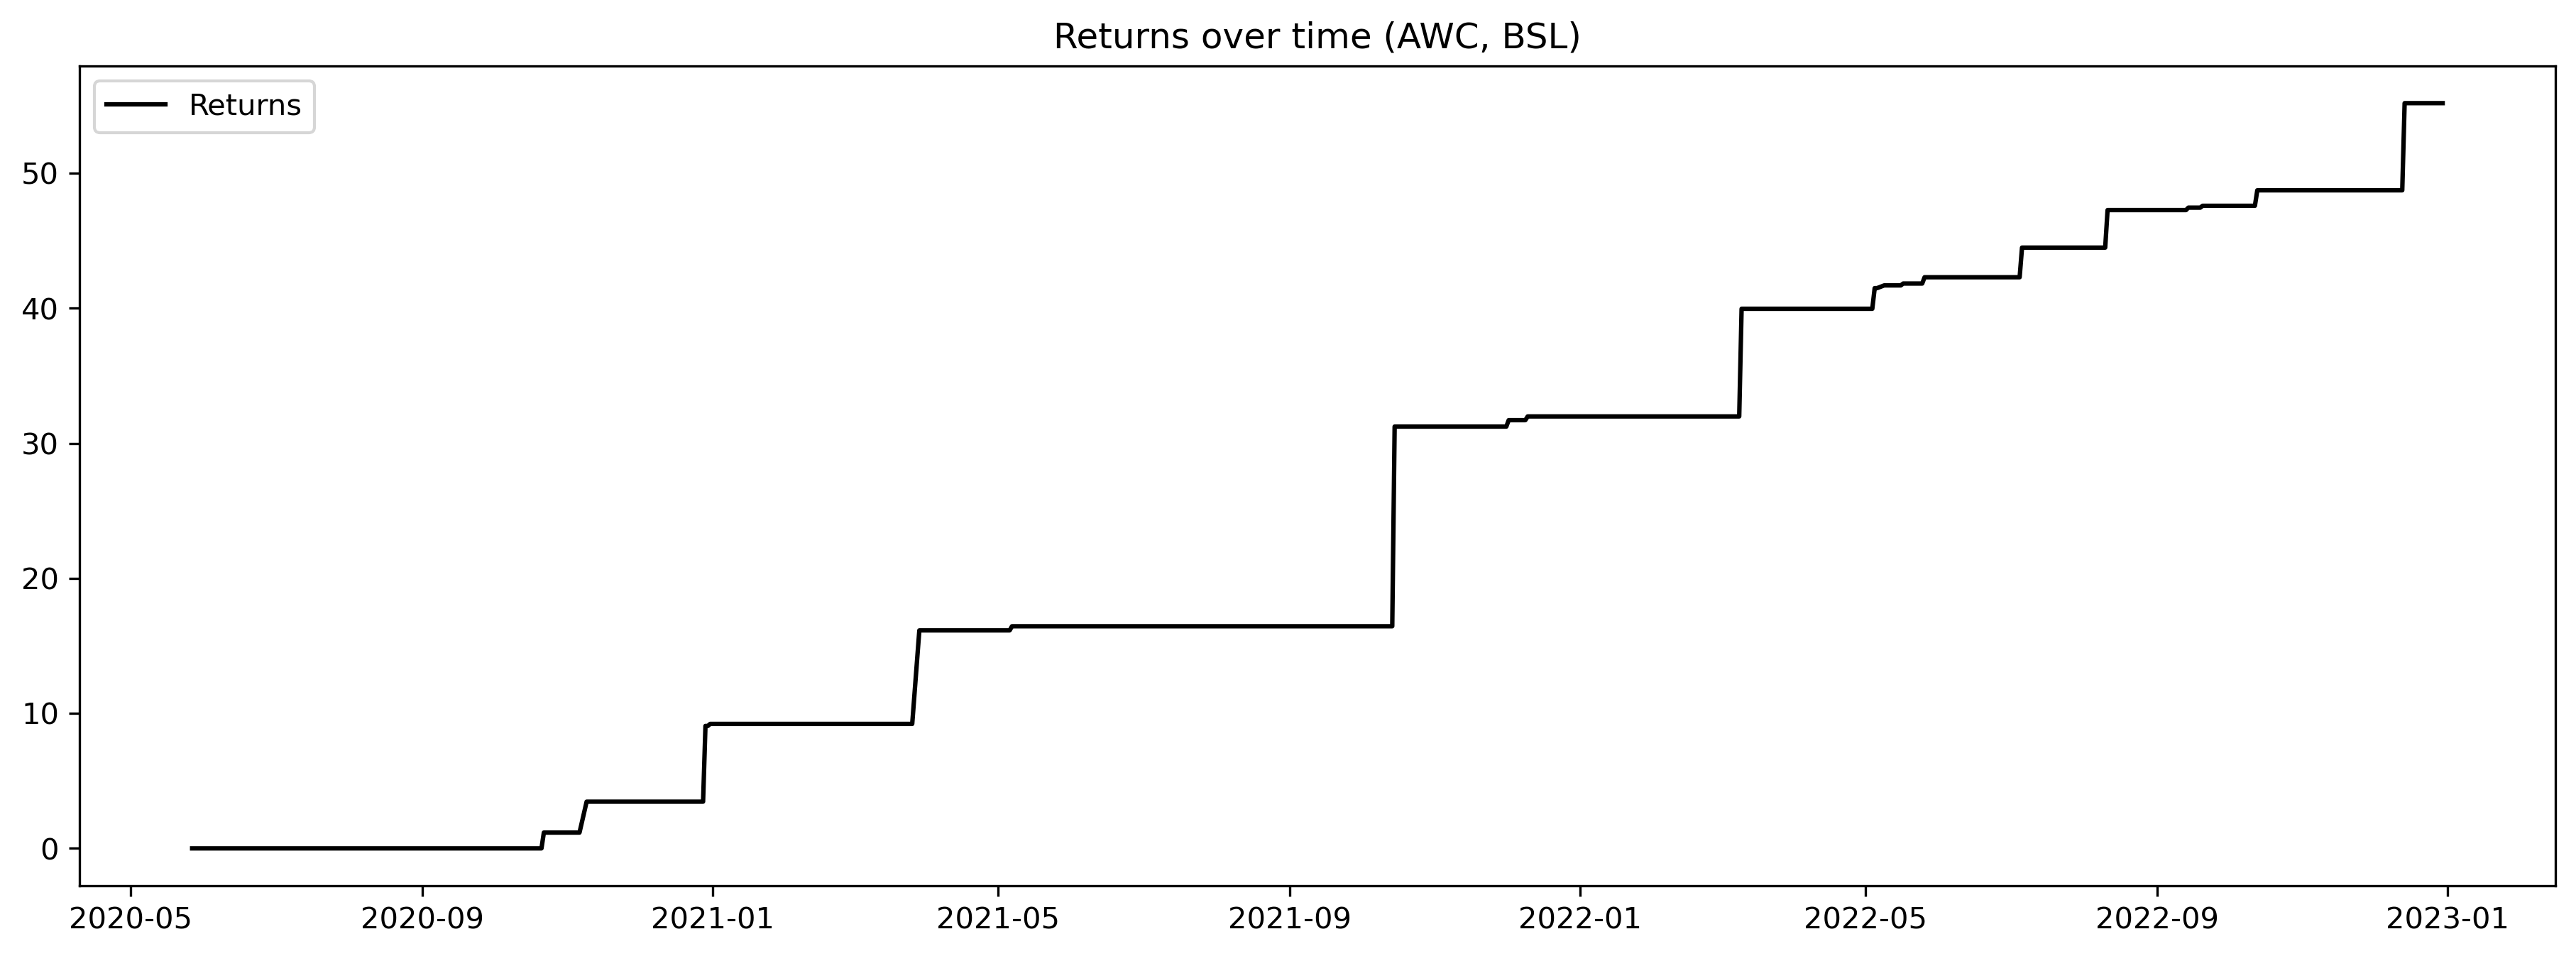

In [204]:
S1 = data[pair[0]]#[train_amount:]
S2 = data[pair[1]] #train_amount:]
window=100
threshold = 0.75
exit_threshold = 0.5

total_returns, returns, amount_S1, amount_S2, initial, returns_S, amount_S1_S, amount_S2_S, buyR_S, sellR_S, ratio = trade(S1, S2, window, threshold, exit_threshold)
print("$"+str(total_returns))

# graphing the returns over time
plt.figure(figsize=(15,5))

# only start after 30 days because that is when the moving averages "start"
plt.title("Returns over time (AWC, BSL)")
plt.plot(returns_S.index, returns_S.values, color='black')
plt.legend(['Returns'])
plt.show()

In [26]:
from statsmodels.tsa.stattools import coint

co = coint(x, y)
co

(-6.099250741449782,
 9.885560533777404e-07,
 array([-3.91102404, -3.34424558, -3.05007972]))

In [7]:
end = dt.datetime(2023, 1, 1)
start = dt.datetime(2003,1,1)

data2 = get_data(['GOOGL', 'GOOG'], start, end)

[*********************100%%**********************]  2 of 2 completed


In [8]:
data2

,GOOG,GOOGL
Date,,
2004-08-19,2.499133,2.511011
2004-08-20,2.697639,2.710460
2004-08-23,2.724787,2.737738
2004-08-24,2.611960,2.624374
2004-08-25,2.640104,2.652653
...,...,...
2022-12-23,89.809998,89.230003
2022-12-27,87.930000,87.389999
2022-12-28,86.459999,86.019997


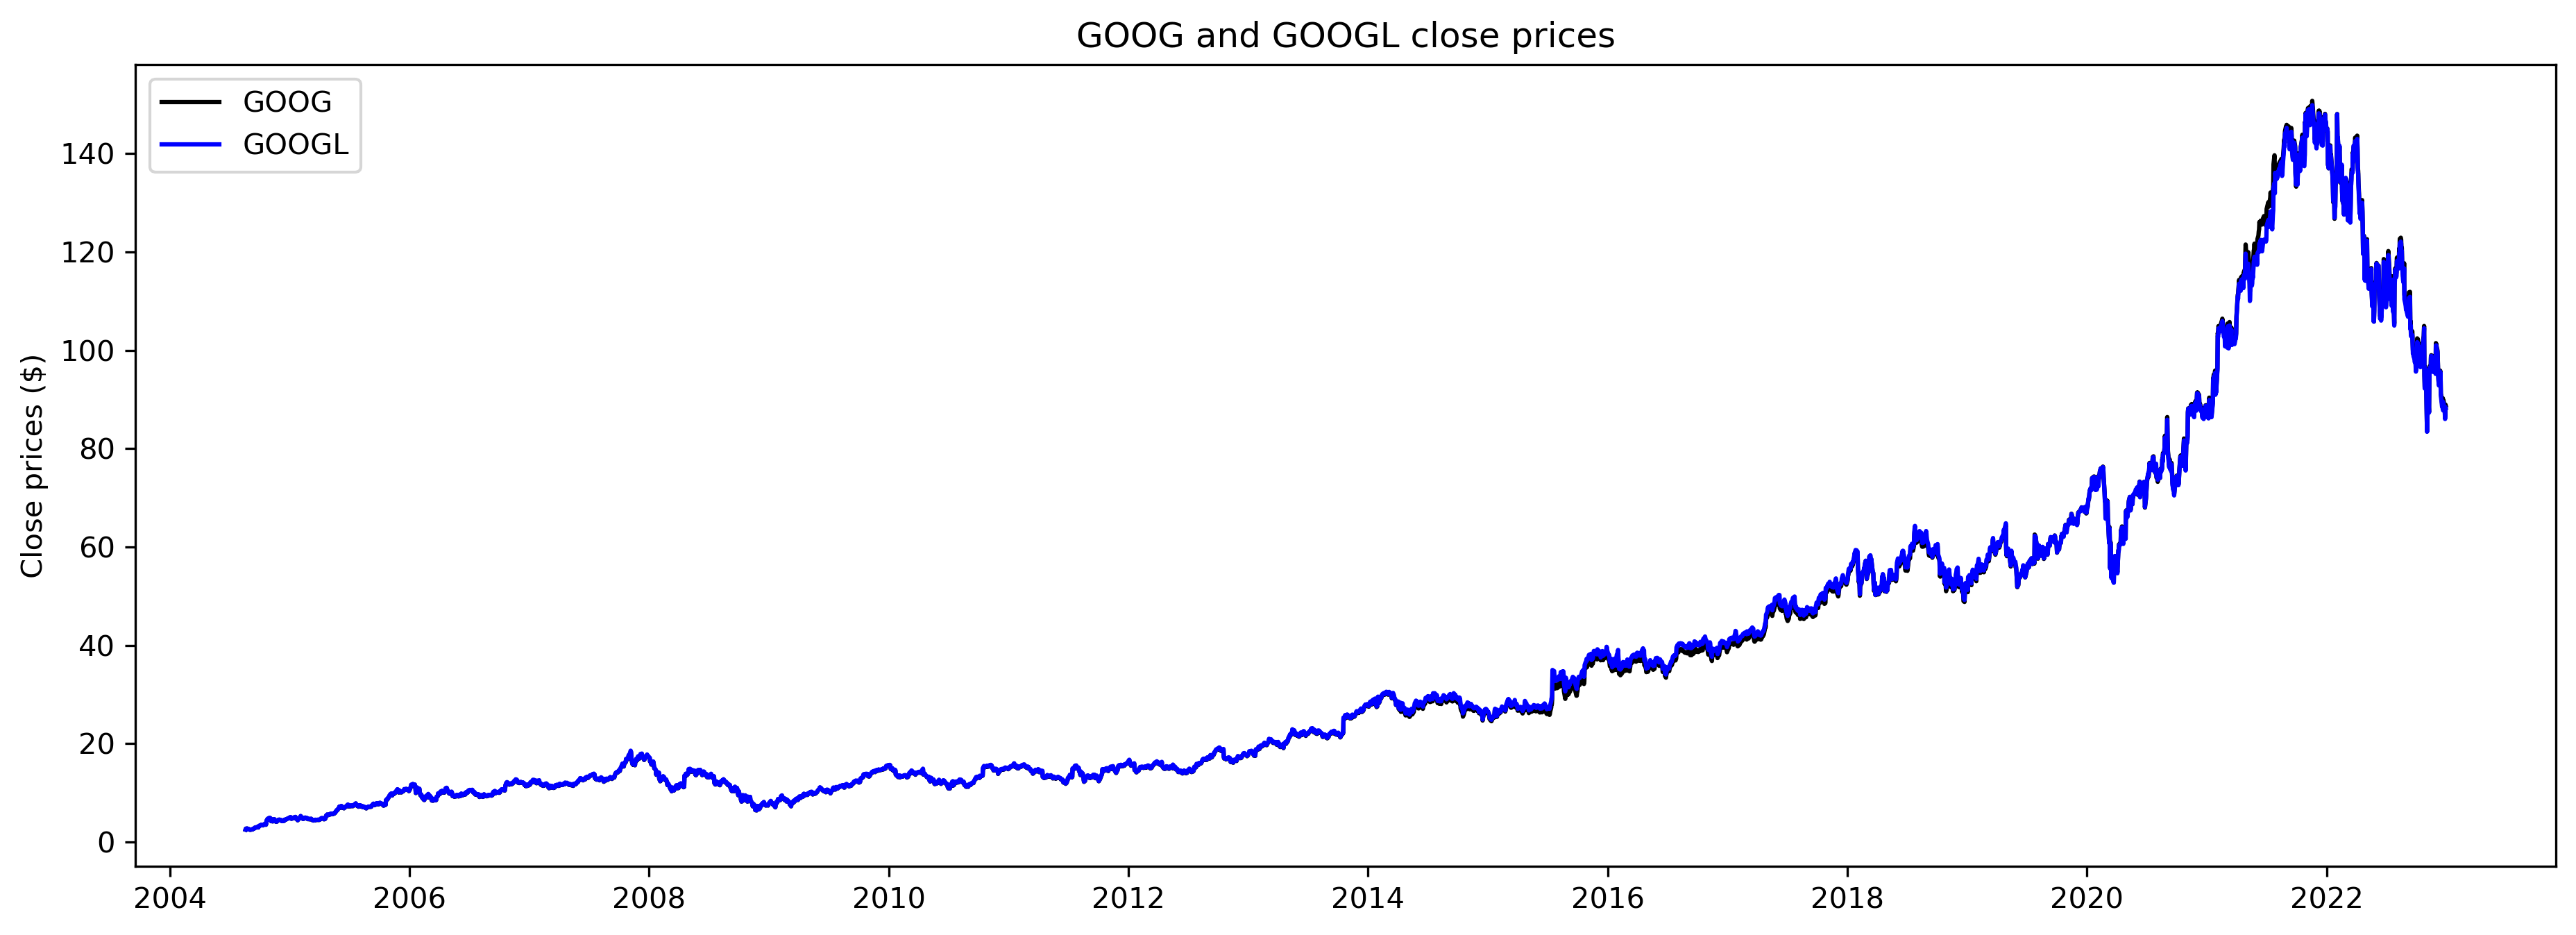

In [11]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(data2.index, data2[pair[0]], color='black')
plt.plot(data2.index, data2[pair[1]], color='blue')


plt.legend([pair[0], pair[1]])
plt.title(f'{pair[0]} and {pair[1]} close prices')
plt.ylabel('Close prices ($)')
plt.show()

In [18]:
(np.log(data) - np.log(data.shift(1)))[1:]

,GOOG,GOOGL
Date,,
2004-08-20,0.076433,0.076433
2004-08-23,0.010013,0.010014
2004-08-24,-0.042289,-0.042290
2004-08-25,0.010717,0.010718
2004-08-26,0.017859,0.017858
...,...,...
2022-12-23,0.017409,0.016612
2022-12-27,-0.021155,-0.020836
2022-12-28,-0.016859,-0.015801


In [20]:
from statsmodels.distributions.empirical_distribution import ECDF

In [32]:
data.apply(lambda x: [ECDF(x)(a) for a in x])

,GOOG,GOOGL
Date,,
2004-08-19,1.000000,1.000000
2004-08-20,0.996108,0.996324
2004-08-23,0.750919,0.751351
2004-08-24,0.021189,0.021622
2004-08-25,0.763459,0.764541
...,...,...
2022-12-23,0.870270,0.860541
2022-12-27,0.088649,0.091459
2022-12-28,0.120216,0.130162


In [40]:
log_data = (np.log(data) - np.log(data.shift(1)))[1:]

In [41]:
log_data.apply(lambda x: [ECDF(x)(a) for a in x])

,GOOG,GOOGL
Date,,
2004-08-20,0.996324,0.996540
2004-08-23,0.751081,0.751514
2004-08-24,0.021194,0.021626
2004-08-25,0.763625,0.764706
2004-08-26,0.876730,0.875433
...,...,...
2022-12-23,0.870458,0.860727
2022-12-27,0.088668,0.091479
2022-12-28,0.120242,0.130190


In [45]:
ary = np.corrcoef(log_data['GOOG'], log_data['GOOGL'])

In [46]:
ary[0][1
       ]

0.9972784497295581

In [178]:
# minutely times
stocks = [pair[0], pair[1]]
start = "2023-09-19"
end = "2023-09-26"
stockData = pdr.get_data_yahoo(stocks, start, end, interval="1m")
stockData = stockData['Adj Close']

[*********************100%%**********************]  2 of 2 completed


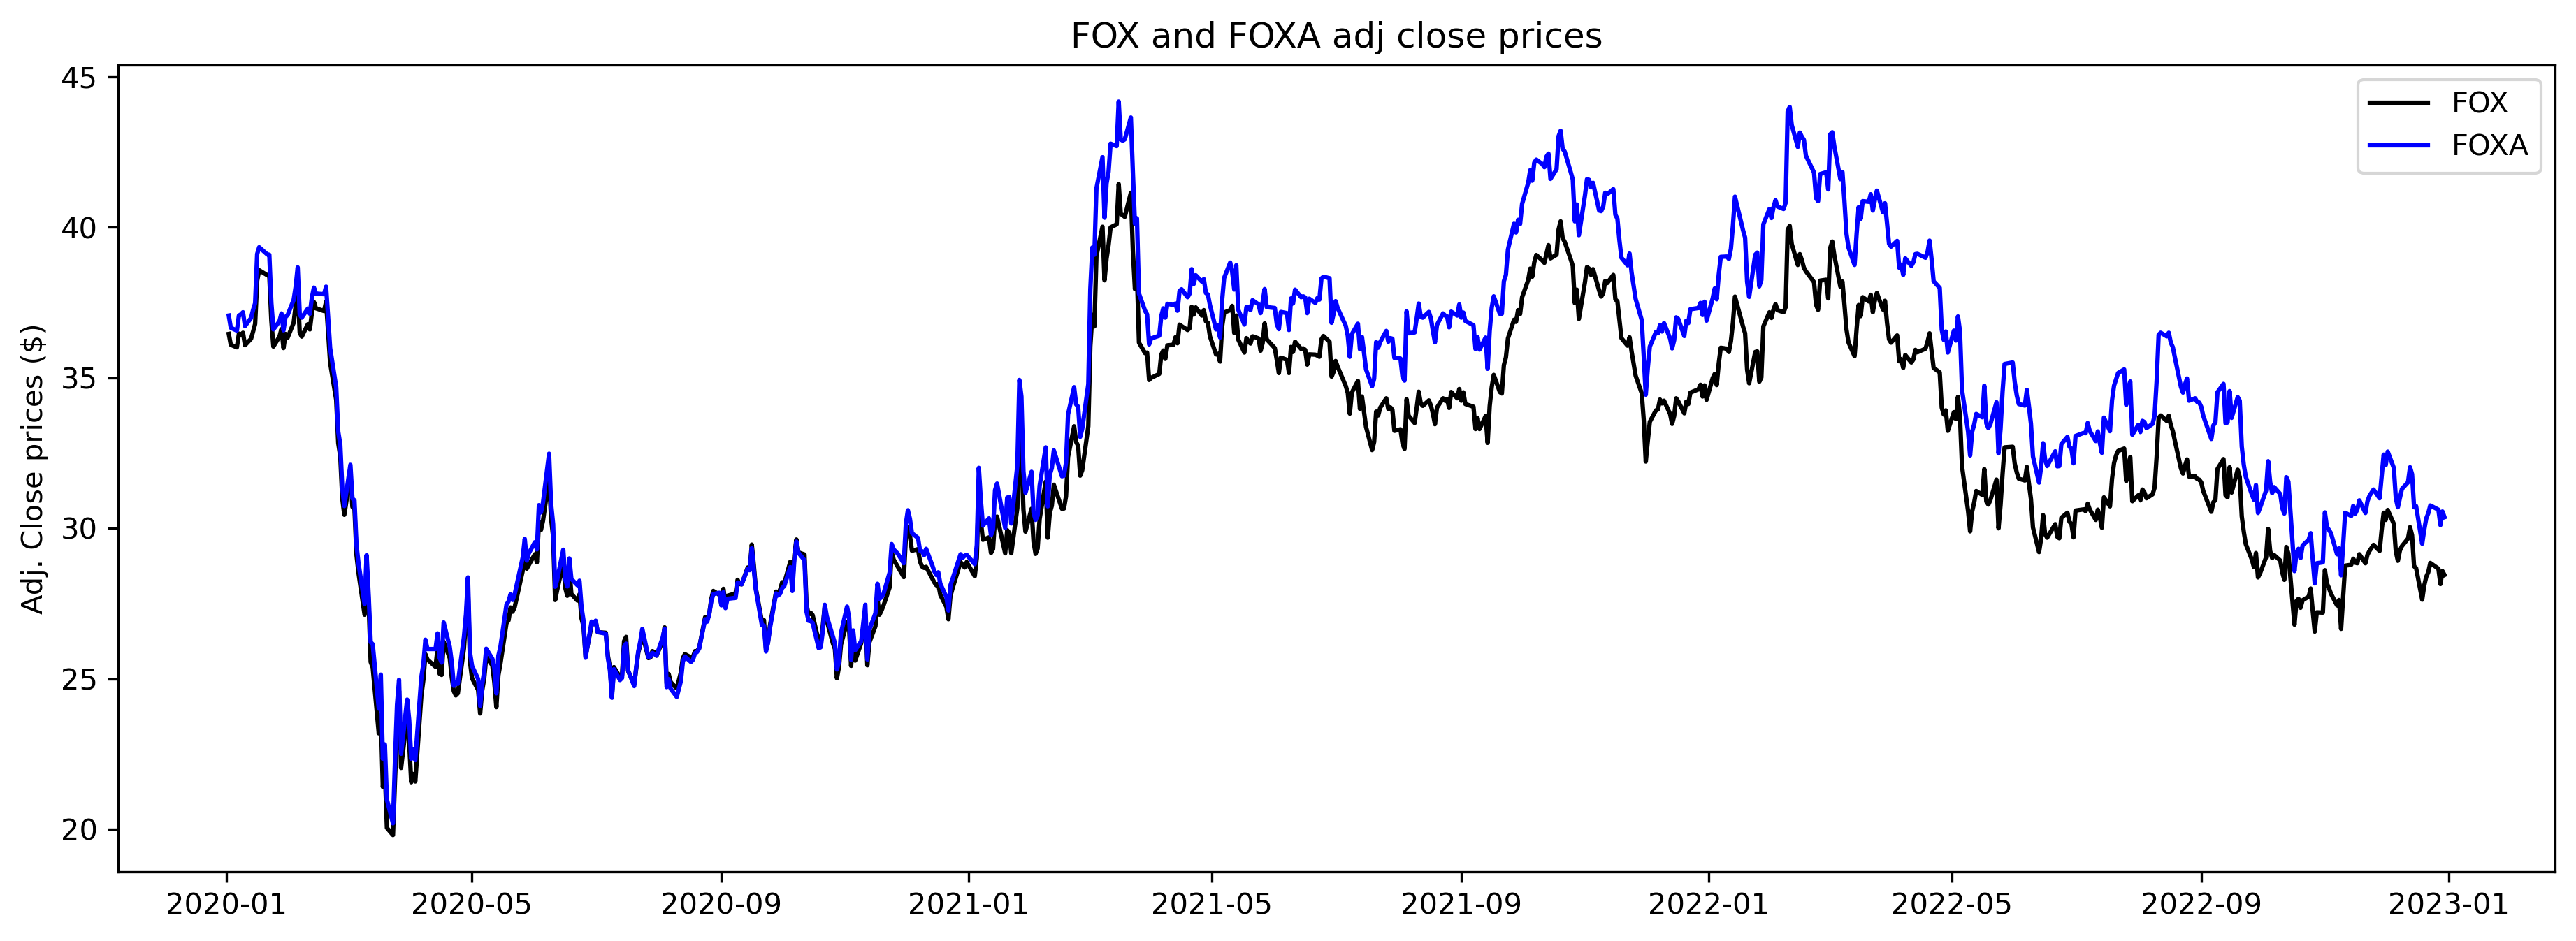

In [201]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(stockData.index, stockData[pair[0]], color='black')
plt.plot(stockData.index, stockData[pair[1]], color='blue')


plt.legend([pair[0], pair[1]])
plt.title(f'{pair[0]} and {pair[1]} adj close prices')
plt.ylabel('Adj. Close prices ($)')
plt.show()

In [151]:
# calculate the ratio (S1/S2)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [223]:
lookback=150
threshold = 1.5
exit_threshold = 0.5
weight = 1
stockData = data[[pair[0], pair[1]]]

selector = pair_selection(stockData) # usually stockdata
selector.get_log_returns()

S1 = stockData[pair[0]]
S2 = stockData[pair[1]]
# data3 = selector.log_return_data[lookback:]

# ratio = data3[pair[0]]/data3[pair[1]]
ratio = S1/S2

def get_moving_z(data_, window, min_p=None):
    # min periods is to prevent having no data at start
    d_ma = data_.rolling(window=window, center=False, min_periods=min_p).mean()
    d_std = data_.rolling(window=window, center=False, min_periods=min_p).std()
    d_z = (data_-d_ma)/d_std
    return d_ma, d_std, d_z

r_ma, r_std, r_Z = get_moving_z(ratio, lookback, min_p=lookback)


# Simulate trading
returns = 0*ratio
amount_S1 = 0*ratio
amount_S2 = 0*ratio
total_returns = 0*ratio
num_trades = 0

for i in range(len(ratio)):
    returns[i] = returns[i-1]
    amount_S1[i] = amount_S1[i-1]
    amount_S2[i] = amount_S2[i-1]

    # sell the ratio if above the threshold, buy one S1 and sell one ratio*S2
    if r_Z[i] > threshold:
        # the returns are the price of S1 - the price of S2 * the amount of S2 bought
        returns[i] += S1[i]*weight - ratio[i]*weight*S2[i]
        amount_S1[i] -= weight
        amount_S2[i] += ratio[i]*weight
        num_trades += 1
        print('sell ratio', ratio[i]*1)
        
    # buy the ratio 
    elif r_Z[i] < -threshold:
        # the returns is the cost of buying S1 + the returns of selling S2 * the amount of S2 sold
        returns[i] += -S1[i]*weight + ratio[i]*weight*S2[i]
        amount_S1[i] += weight
        amount_S2[i] -= ratio[i]*weight
        num_trades += 1

        print('buy ratio', ratio[i]*1)

    # exit positions
    elif abs(r_Z[i]) < exit_threshold:
        returns[i] += amount_S1[i]*S1[i] + amount_S2[i]*S2[i]
        amount_S1[i] = 0
        amount_S2[i] = 0

    total_returns[i] = returns[i] + amount_S1[i]*S1[i] + amount_S2[i]*S2[i]

num_trades, total_returns[-1]

sell ratio 1.6655948562914717
sell ratio 1.70307441923663
sell ratio 1.7377048789782865
sell ratio 1.745411117742095
sell ratio 1.7348543800850593
sell ratio 1.7247634316149345
sell ratio 1.7185771088303008
sell ratio 1.7311203552005443
sell ratio 1.712947274481608
sell ratio 1.7480785009966344
sell ratio 1.7592745219501154
sell ratio 1.7743026125517085
sell ratio 1.7870912950081506
sell ratio 1.7642617912787764
sell ratio 1.7913256064904168
sell ratio 1.7829153285206165
sell ratio 1.7873015695208119
sell ratio 1.772796367341437
sell ratio 1.7813672679925772
sell ratio 1.7820121466998253
sell ratio 1.7697517325262861
sell ratio 1.8048399751672448
sell ratio 1.7940015315994375
sell ratio 1.8027735318778508
sell ratio 1.7989172219563703
sell ratio 1.8035993520088835
sell ratio 1.8157492460650362
sell ratio 1.8921094891822465
sell ratio 1.8325687655327518
sell ratio 1.8156134143193101
sell ratio 1.8038462125338042
sell ratio 1.813935046700215
sell ratio 1.8096775180963554
sell ratio 1.811

(137, 156.39866779971499)

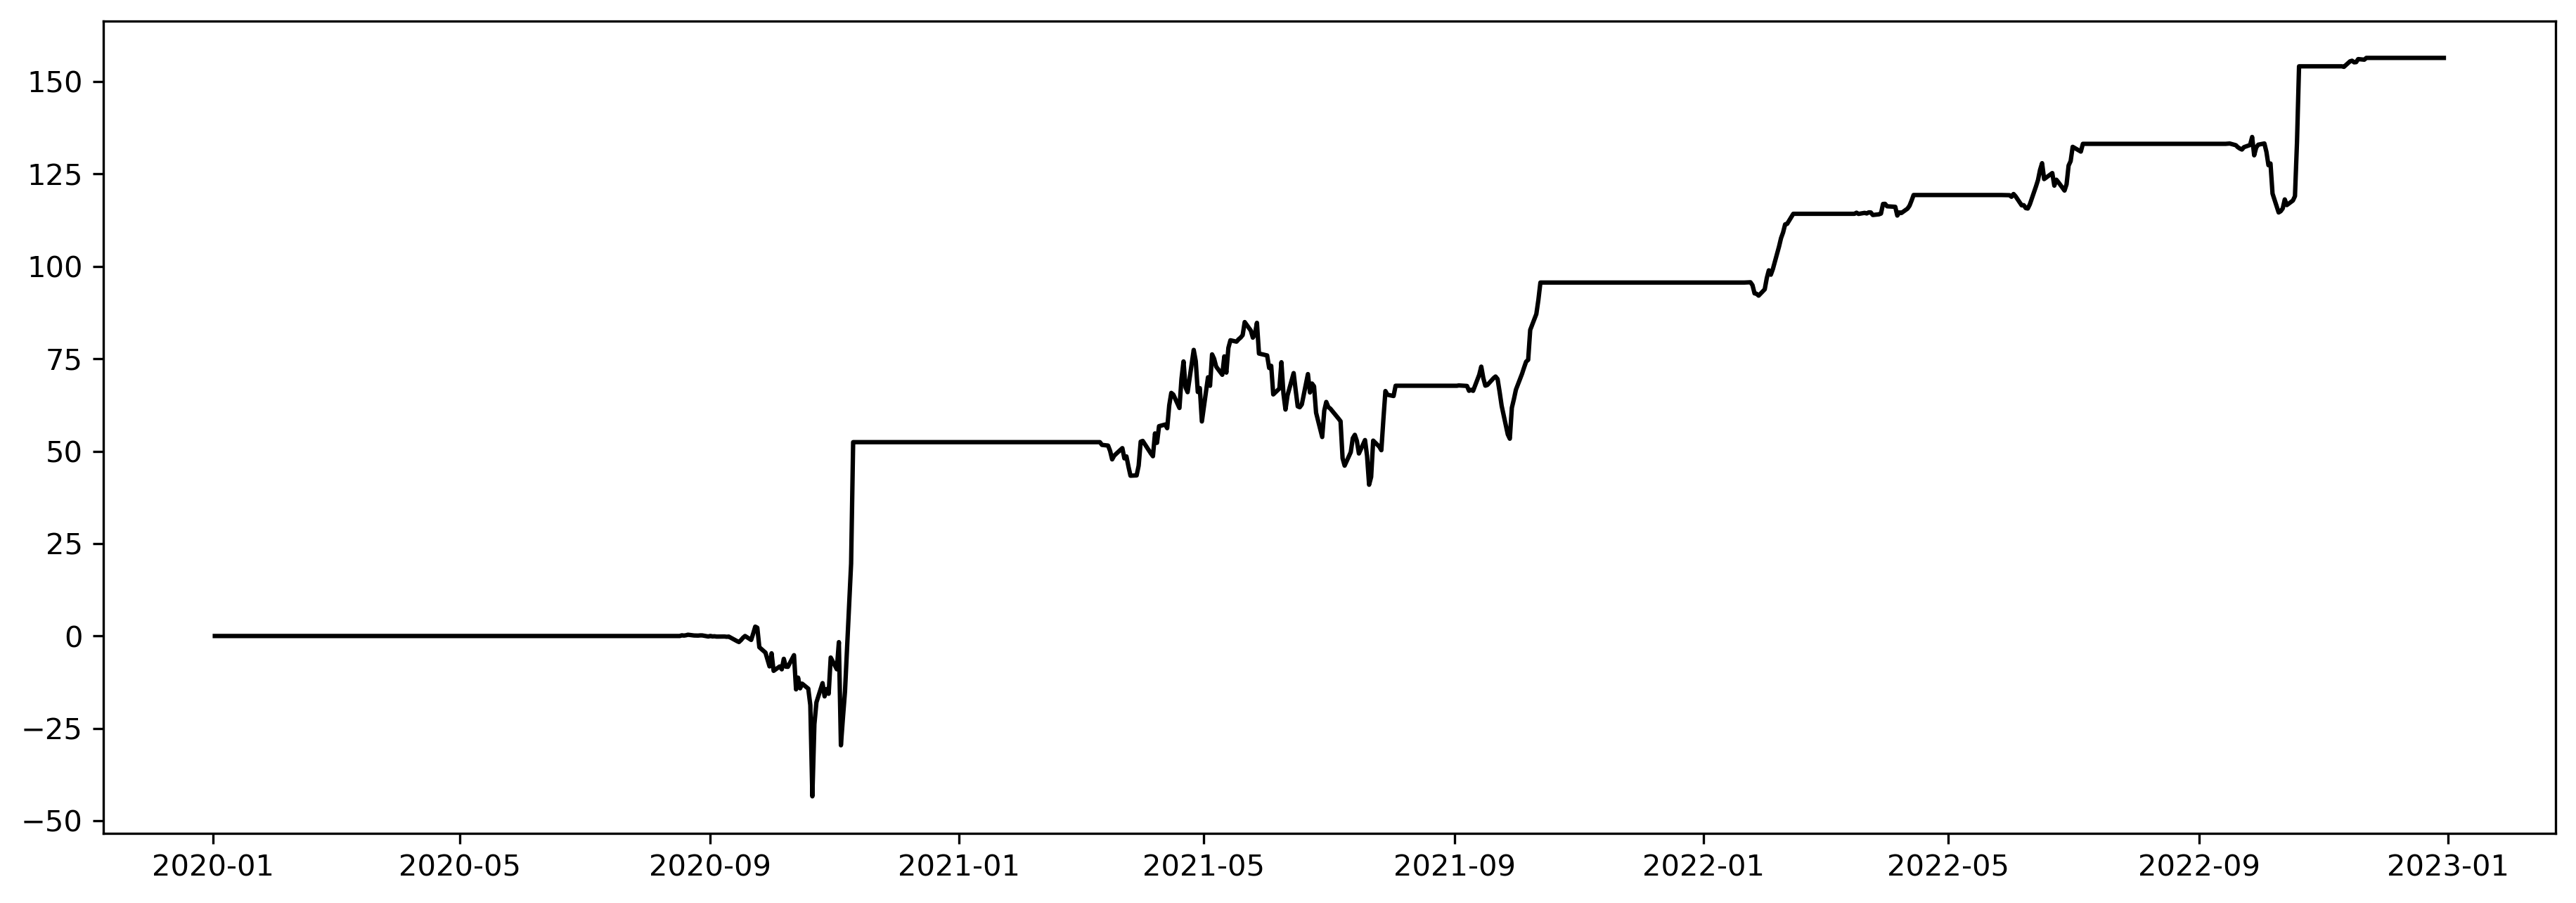

In [224]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(total_returns, color='black')
plt.show()

In [149]:
ratio

Datetime
2023-09-21 11:01:00-04:00    0.858089
2023-09-21 11:02:00-04:00    0.608901
2023-09-21 11:03:00-04:00    1.323393
2023-09-21 11:04:00-04:00    0.882162
2023-09-21 11:05:00-04:00    0.992411
                               ...   
2023-09-25 15:55:00-04:00    1.031627
2023-09-25 15:56:00-04:00    0.881629
2023-09-25 15:57:00-04:00    0.000000
2023-09-25 15:58:00-04:00   -0.000000
2023-09-25 15:59:00-04:00    0.992055
Length: 1079, dtype: float64

In [ ]:

def moving_data(data, window, std=False, z=False, min_periods=None):
    # min periods is to prevent having no data at start
    d_ma = data.rolling(window=window, center=False, min_periods=None).mean()
    if std or z:
        d_std = data.rolling(window=window, center=False, min_periods=None).std()
        if std:
            return d_ma, d_std
    if z:
        d_z = (data-d_ma)/d_std
        return d_ma, d_std, d_z
    return d_ma

# testing cointegration approach
def trade(S1, S2, window, threshold, exit_threshold, start_S1=0, start_S2=0): # use the testing data for S1 and S2
    S1 = S1[window:]
    S2 = S2[window:]
    ratio = S1/S2
    r_MA, r_STD, r_Z = moving_data(ratio, window, z=True)

    # variables for graphing
    returns_S = 0*ratio.copy()
    amount_S1_S = 0*ratio.copy()
    amount_S2_S = 0*ratio.copy()
    buyR_S = 0*ratio.copy()
    sellR_S = 0*ratio.copy()

    # Simulate trading
    returns = 0
    amount_S1 = start_S1
    amount_S2 = start_S2
    initial = returns + amount_S1*S1[0] + amount_S2*S2[0]
    for i in range(len(ratio)):
        # sell the ratio if above the threshold, buy one S1 and sell one ratio*S2
        if r_Z[i] > threshold:
            # the returns are the price of S1 - the price of S2 * the amount of S2 bought
            returns += S1[i] - ratio[i]*S2[i]
            amount_S1 -= 1
            amount_S2 += ratio[i]*1
            sellR_S[i] = ratio[i]
            
        # buy the ratio 
        elif r_Z[i] < -threshold:
            # the returns is the cost of buying S1 + the returns of selling S2 * the amount of S2 sold
            returns += -S1[i] + ratio[i]*S2[i]
            amount_S1 += 1
            amount_S2 -= ratio[i]*1
            buyR_S[i] = ratio[i]

        # exit positions
        elif abs(r_Z[i]) < exit_threshold:
            returns += amount_S1*S1[i] + amount_S2*S2[i]
            amount_S1 = 0
            amount_S2 = 0
        
        # add values to time series
        returns_S[i] = returns
        amount_S1_S[i] = amount_S1
        amount_S2_S[i] = amount_S2

    total_returns = returns + amount_S1*S1[-1] + amount_S2*S2[-1]

    # return total returns, cash returns, anmount of S1 stock, amount of S2 stock, time series
    # output = {"Data":{"Total Returns":total_returns,"Returns"}}
    return total_returns, returns, amount_S1, amount_S2, initial, returns_S, amount_S1_S, amount_S2_S, buyR_S, sellR_S, ratio        

6

In [221]:
pair_selector = pair_selection(data.drop(columns=['GOOG', 'FOXA', 'NWSA']))
pair = pair_selector.kendall_tau()
pair # ('GOOG', 'GOOGL')

100%|██████████| 491/491 [00:26<00:00, 18.28it/s]


('FITB', 'KEY')

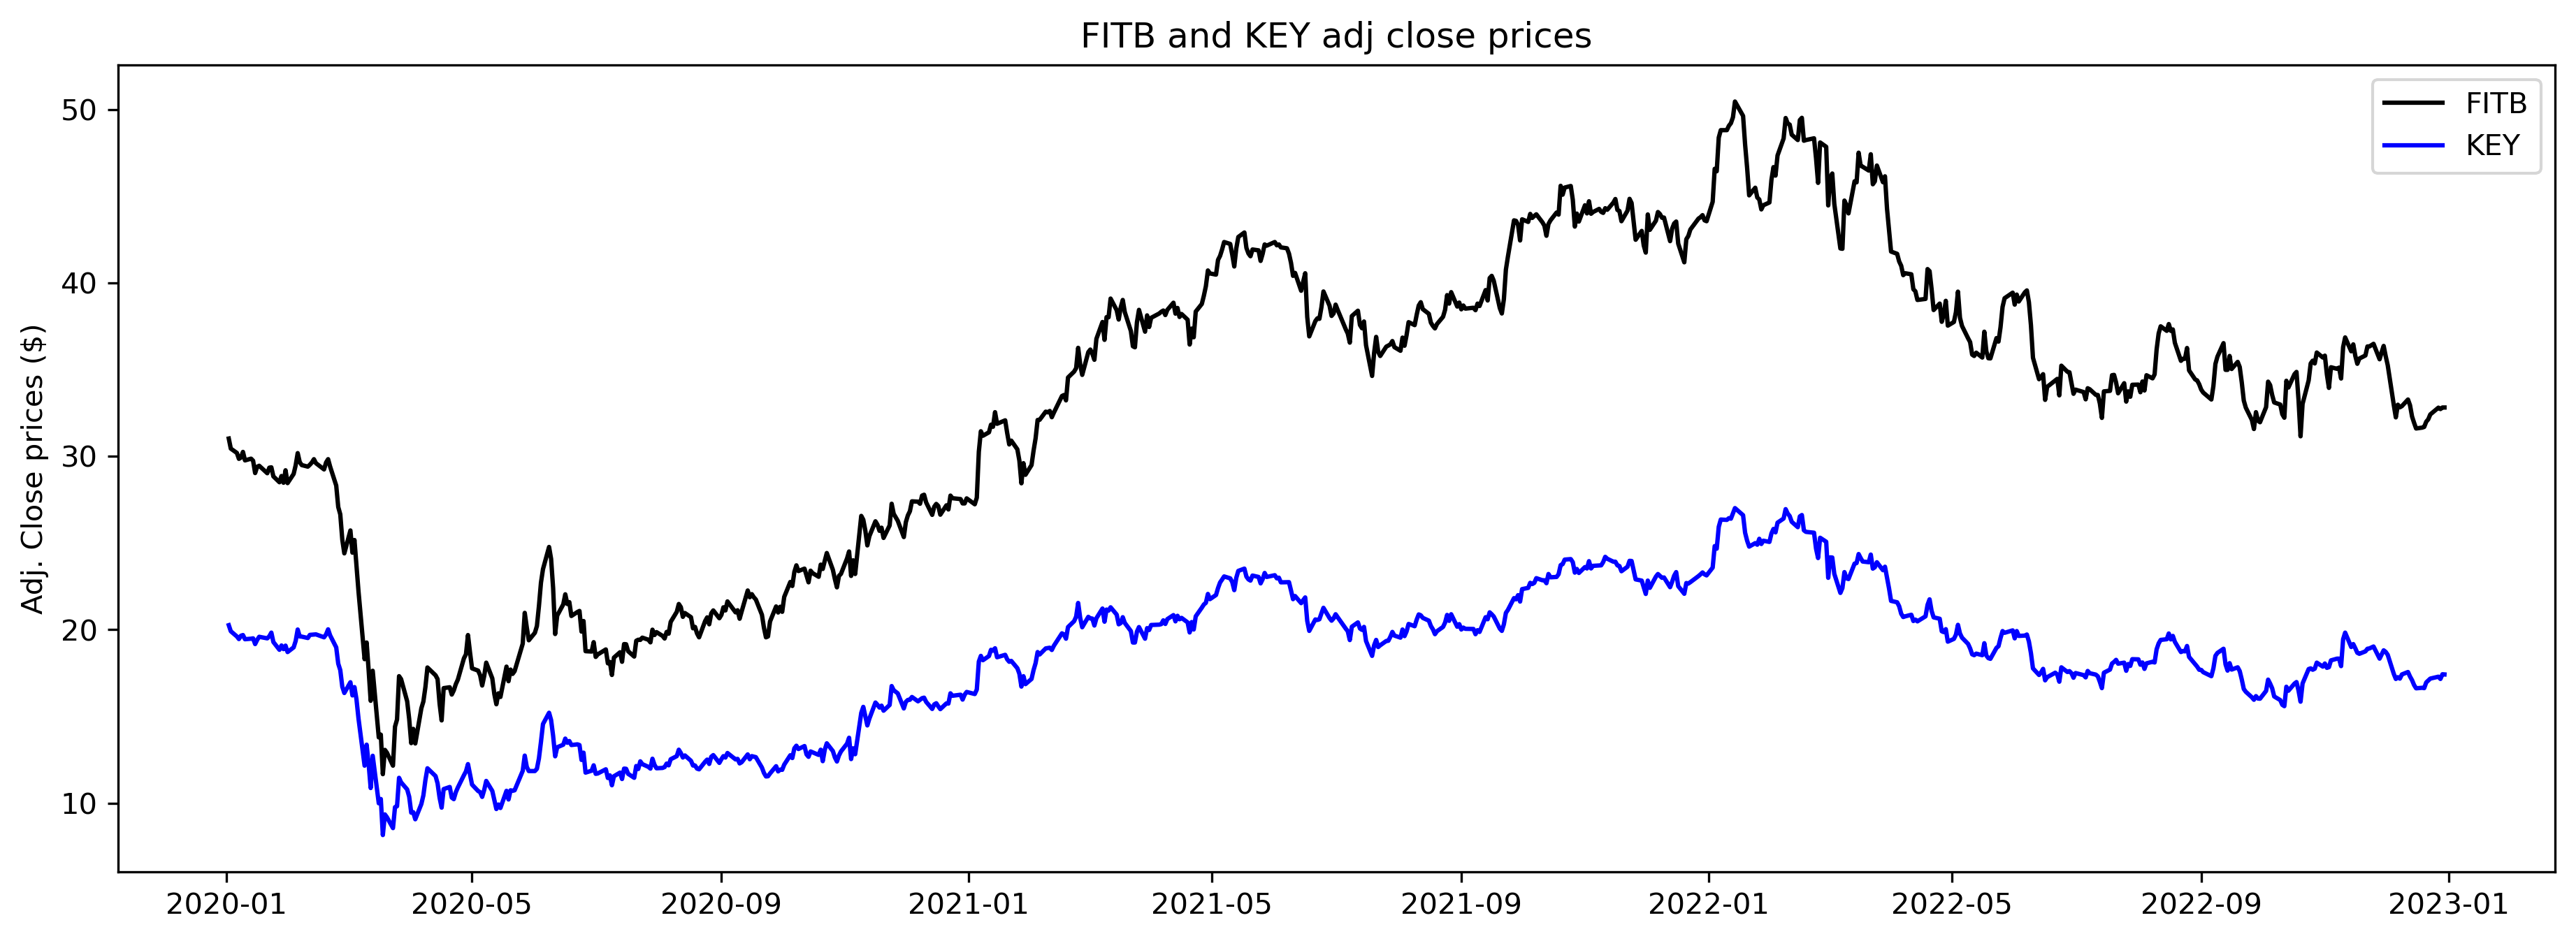

In [222]:
# Plot the two stocks
plt.figure(figsize=(15,5))
plt.plot(data.index, data[pair[0]], color='black')
plt.plot(data.index, data[pair[1]], color='blue')


plt.legend([pair[0], pair[1]])
plt.title(f'{pair[0]} and {pair[1]} adj close prices')
plt.ylabel('Adj. Close prices ($)')
plt.show()

In [9]:
from statsmodels.tsa.stattools import coint

pairs

[('GOOG', 'GOOGL'),
 ('FOX', 'FOXA'),
 ('NWS', 'NWSA'),
 ('FITB', 'KEY'),
 ('CFG', 'KEY')]

In [21]:
pair = pairs[0]
coint(pair_selector.log_return_data['A'],pair_selector.log_return_data["AAL"])

(-9.293478244709215,
 1.548029549295369e-14,
 array([-3.91102404, -3.34424558, -3.05007972]))

In [20]:
pair_selector.log_return_data

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.016186,-0.050769,-0.009770,-0.009537,-0.012266,-0.001153,-0.001667,-0.007865,-0.017760,-0.001954,...,-0.014944,0.004798,-0.008072,-0.011128,0.005869,-0.003137,-0.002617,-0.011996,-0.014212,0.000149
2020-01-06,0.002952,-0.012007,0.007937,0.007861,0.005226,0.003914,-0.006551,0.005710,-0.011818,-0.007853,...,-0.001981,-0.001437,0.007649,0.005491,-0.006495,-0.000589,-0.005796,0.007626,-0.012261,-0.007707
2020-01-07,0.003061,-0.003667,-0.004714,-0.005721,-0.005575,-0.008306,-0.021826,-0.000959,0.022496,-0.012119,...,0.004734,-0.002079,-0.008218,0.005285,-0.003767,0.001767,-0.000879,-0.005987,-0.006089,0.003374
2020-01-08,0.009825,0.022522,0.015958,0.007062,0.004068,-0.010013,0.001960,0.013348,0.008991,-0.011146,...,0.006254,-0.000961,-0.015195,0.010488,0.003390,0.001764,0.011903,-0.035036,0.009802,-0.002173
2020-01-09,0.015590,0.003943,0.021018,0.007678,0.002664,0.020156,0.008868,0.007607,0.000000,-0.010365,...,-0.004212,0.002241,0.007626,0.000695,0.004503,0.007898,-0.006640,-0.004614,0.006611,0.013192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.001475,0.011872,-0.002802,-0.001042,0.001388,0.008397,0.005011,0.005719,0.000549,0.012014,...,-0.006421,0.012770,0.026101,0.011057,-0.000729,0.000621,-0.000789,0.002864,0.003515,0.005021
2022-12-27,0.002142,-0.014263,-0.013976,-0.000675,0.003599,0.003779,-0.002936,-0.009977,-0.010060,0.013541,...,0.043751,0.008983,0.013798,0.007512,0.008982,0.007728,0.004646,0.011137,0.008017,-0.003161
2022-12-28,-0.009811,-0.016902,-0.031166,-0.004674,-0.006839,-0.016163,-0.008289,-0.020380,-0.011908,-0.024166,...,-0.051587,-0.014071,-0.016563,-0.034579,-0.016207,-0.004552,-0.010187,-0.016713,-0.017974,-0.010169


In [5]:
pairs = pair_selector.cointegration()
pair = pairs[0] # ('GOOG', 'GOOGL')
pairs

  0%|          | 1/494 [00:14<2:01:43, 14.81s/it]/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/pairlib.py:88: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

  0%|          | 2/494 [00:29<2:03:04, 15.01s/it]/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/pairlib.py:88: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

  1%|          | 3/494 [00:44<2:01:54, 14.90s/it]/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/pairlib.py:88: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.

  1%|          | 4/494 [01:02<2:11:19, 16.08s/it]/Users/jasperchong/PycharmProjects/Statistical Arbitrage/Copulas pair trading/pairlib.py:88: CollinearityWarning:

y0 and y1 are (almost) perfectly colinear.Cointegration test is not 

KeyboardInterrupt: 